# Decoding Sector Valuation Dynamics

Exploring the Nexus of Company Fundamentals, Economic Indicators, and Equity Valuations via Predictive Analytics


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import Utils

%matplotlib inline

# Plot Colors
PRIMARY_COLOR = "#1799E7"
SECONDARY_COLOR = "black"
DASH_COLOR = "dimgrey"


# Display everything
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load the data
df = pd.read_csv('data/preprocessed.csv')

utils = Utils()

# Display info
display(df.shape)
display(df.dtypes)
print('\nNulls:')
display(df.isnull().sum().sort_values())
print('\nNot Null:')
not_null = df.notna().sum().sort_values()
display(not_null)

(154291, 72)

symbol                            object
cap                               object
GICS Sector ID                     int64
GICS Sector                       object
GICS Industry Group ID             int64
GICS Industry Group               object
GICS Industry ID                 float64
GICS Industry                     object
GICS Sub-Industry ID             float64
GICS Sub-Industry                 object
date                              object
adjclose                         float64
TotalRevenue                     float64
OperatingRevenue                 float64
NetIncome                        float64
BasicEPS                         float64
DilutedEPS                       float64
EBITDA                           float64
EBIT                             float64
Current Ratio                    float64
Quick Ratio                      float64
Gross Profit Margin              float64
Net Profit Margin                float64
Cash Flow Margin                 float64
Operating Margin


Nulls:


symbol                                0
coffee                                0
soybean                               0
corn                                  0
wheat                                 0
natural_gas                           0
palladium                             0
platinum                              0
treasury_10yr                         0
copper                                0
oil                                   0
gold                                  0
vix                                   0
treasury_3mo                          0
aaa_credit_spread                     0
baa_credit_spread                     0
treasury_2yr                          0
silver                                0
sugar                                 0
cocao                                 0
mortgage_30yr                         0
cap                                   0
GICS Sector ID                        0
GICS Sector                           0
GICS Industry Group ID                0



Not Null:


R&D to Revenue                    11030
Inventory Turnover                22837
Quick Ratio                       27159
Interest Coverage                 32071
Efficiency Ratio                  32189
BasicEPS                          34404
DilutedEPS                        34404
ROE                               35396
CROA                              35396
ROA                               35396
Operating Margin                  35396
Cash Flow Margin                  35396
Net Profit Margin                 35396
Gross Profit Margin               35396
Current Ratio                     35396
EBIT                              35396
EBITDA                            35396
Book Value Per Share              35396
OperatingRevenue                  35396
TotalRevenue                      35396
Debt to Equity                    35396
Debt Ratio                        35396
Cash Flow to Debt                 35396
Assets to Equity                  35396
Investment CF to OCF              35396


## Analysis and Feature Selection


In [2]:
# Convert object cols and sector/industry IDs to category
cat_cols = ['symbol', 'cap']
cat_cols += [col for col in df.columns if 'GICS' in col]

for col in cat_cols:
    df[col] = df[col].astype('category')

# Convert date to datetime
df['date'] = df['date'].astype('datetime64[s]')

# Convert floats to 32bit for memory efficiency
for col in df.select_dtypes(include='float64').columns:
    df[col] = df[col].astype('float32')

print('Total companies:', df['symbol'].nunique())
display(df.head(5))

Total companies: 1492


symbol    cap GICS Sector ID  GICS Sector GICS Industry Group ID  \
0      A  large             35  Health Care                   3520   
1      A  large             35  Health Care                   3520   
2      A  large             35  Health Care                   3520   
3      A  large             35  Health Care                   3520   
4      A  large             35  Health Care                   3520   

                              GICS Industry Group GICS Industry ID  \
0  Pharmaceuticals, Biotechnology & Life Sciences         352030.0   
1  Pharmaceuticals, Biotechnology & Life Sciences         352030.0   
2  Pharmaceuticals, Biotechnology & Life Sciences         352030.0   
3  Pharmaceuticals, Biotechnology & Life Sciences         352030.0   
4  Pharmaceuticals, Biotechnology & Life Sciences         352030.0   

                    GICS Industry GICS Sub-Industry ID  \
0  Life Sciences Tools & Services           35203010.0   
1  Life Sciences Tools & Services           35203010.0   
2  Life Sciences Tools & Services           35203010.0   
3  Life Sciences Tools & Services           35203010.0   
4  Life Sciences Tools & Services           35203010.0   

                GICS Sub-Industry       date  adjclose  TotalRevenue  \
0  Life Sciences Tools & Services 2014-01-31  0.016787           NaN   
1  Life Sciences Tools & Services 2014-02-28 -0.020980     -0.413271   
2  Life Sciences Tools & Services 2014-03-31 -0.017741           NaN   
3  Life Sciences Tools & Services 2014-04-30 -0.031280           NaN   
4  Life Sciences Tools & Services 2014-05-30  0.053664     -0.019841   

   OperatingRevenue  NetIncome  BasicEPS  DilutedEPS    EBITDA      EBIT  \
0               NaN        NaN       NaN         NaN       NaN       NaN   
1         -0.413271  -0.075829 -0.078125   -0.079365 -0.414248 -0.556338   
2               NaN        NaN       NaN         NaN       NaN       NaN   
3               NaN        NaN       NaN         NaN       NaN       NaN   
4         -0.019841  -0.287179 -0.237288   -0.224138 -0.117117 -0.214286   

   Current Ratio  Quick Ratio  Gross Profit Margin  Net Profit Margin  \
0            NaN          NaN                  NaN                NaN   
1       0.052895     0.052170            -0.042702           0.575124   
2            NaN          NaN                  NaN                NaN   
3            NaN          NaN                  NaN                NaN   
4      -0.044896    -0.032866            -0.029769          -0.272750   

   Cash Flow Margin  Operating Margin       ROA      CROA       ROE  \
0               NaN               NaN       NaN       NaN       NaN   
1         -0.122953         -0.258452 -0.071659 -0.483089 -0.102637   
2               NaN               NaN       NaN       NaN       NaN   
3               NaN               NaN       NaN       NaN       NaN   
4          0.709170         -0.226590 -0.312263  0.616306 -0.310227   

   Efficiency Ratio  Inventory Turnover  Debt to Equity  Debt Ratio  \
0               NaN                 NaN             NaN         NaN   
1          0.038654            0.646016       -0.030446    0.003023   
2               NaN                 NaN             NaN         NaN   
3               NaN                 NaN             NaN         NaN   
4          0.030982           -0.449188       -0.033051   -0.035906   

   Interest Coverage  Cash Flow to Debt  Assets to Equity  R&D to Revenue  \
0                NaN                NaN               NaN             NaN   
1          -0.541039          -0.484647         -0.033368       -0.133040   
2                NaN                NaN               NaN             NaN   
3                NaN                NaN               NaN             NaN   
4          -0.240476           0.676502          0.002961        0.008649   

   Investment CF to OCF  Financing CF to OCF  FreeCashFlow     Capex  \
0                   NaN                  NaN           NaN       NaN   
1              0.4416

In [3]:
# Target variable (adjusted close %)
target = df.select_dtypes(include='float32').columns[0]

def get_features(df: pd.DataFrame, target: str = target, lag: str = '_lag'):
    """Returns the features and lag features (if any) from the DataFrame"""
    # Select float64 columns that are not the target
    features = np.array(df.drop(columns=[target]).select_dtypes(
        include='float32').columns)
    lag_features = np.array(
        [feature for feature in features if lag in feature])
    features = np.array([
        feature for feature in features if feature not in lag_features])
    return features, lag_features


features, _ = get_features(df)

# Ensure sorted by symbol and date
df = df.sort_values(by=['symbol', 'date'])

print('Target:', target)
print('\nFeatures:')
for feature in features:
    print(feature)

Target: adjclose

Features:
TotalRevenue
OperatingRevenue
NetIncome
BasicEPS
DilutedEPS
EBITDA
EBIT
Current Ratio
Quick Ratio
Gross Profit Margin
Net Profit Margin
Cash Flow Margin
Operating Margin
ROA
CROA
ROE
Efficiency Ratio
Inventory Turnover
Debt to Equity
Debt Ratio
Interest Coverage
Cash Flow to Debt
Assets to Equity
R&D to Revenue
Investment CF to OCF
Financing CF to OCF
FreeCashFlow
Capex
Book Value Per Share
Tangible Book Value Per Share
fed_funds
treasury_10yr
treasury_2yr
baa_credit_spread
aaa_credit_spread
treasury_3mo
vix
gold
oil
silver
copper
aluminium
platinum
palladium
natural_gas
wheat
corn
soybean
coffee
cocao
sugar
cotton
mortgage_30yr
mortgage_15yr
cpi
unemployment
federal_budget_deficit
housing_starts
gdp_real
avg_home_price


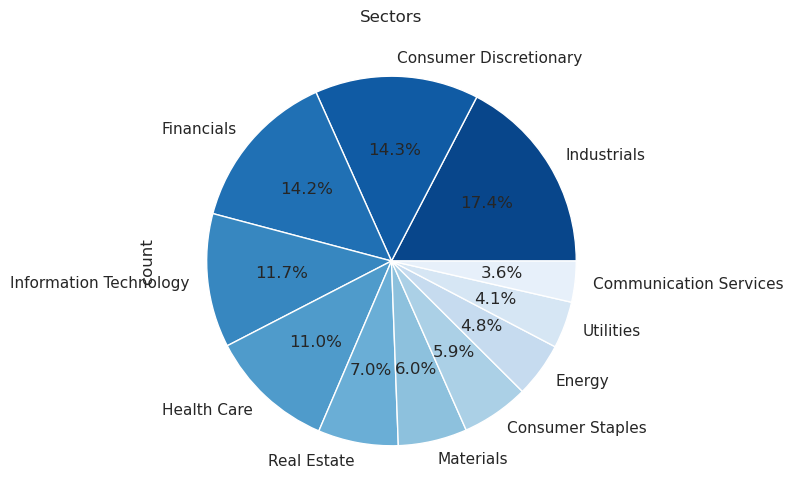

In [4]:
# Pi-chart of Sectors
custom_palette = sns.color_palette("Blues", n_colors=len(df['GICS Sector'].unique()))[::-1]

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.title('Sectors')
df['GICS Sector'].value_counts().plot.pie(autopct='%1.1f%%', colors=custom_palette)
plt.show()

Industrials, Consumer Discretionary, and Financials are the most represented sectors in the dataset. These 3 sectors account for nearly 50% of the dataset. These 3 especially may benefit from splitting into sub-sectors for more granular analysis.

### Multicollinearity

For any predictive model, it is important to identify and address multicollinearity, which is the phenomenon where two or more independent variables in a regression model are highly correlated. This can lead to unreliable and unstable estimates of the coefficients, which can make it difficult to assess the effect of each feature on the dependent variable.

Several linear-regression methods are robust to multicollinearity (e.g., Lasso, Ridge, and ElasticNet) to a certain degree, as well as decision tree based models (e.g., Random Forest and Gradient Boosting). However, extremely high correlations between features still pose a problem for these models.

#### Correlation Matrix

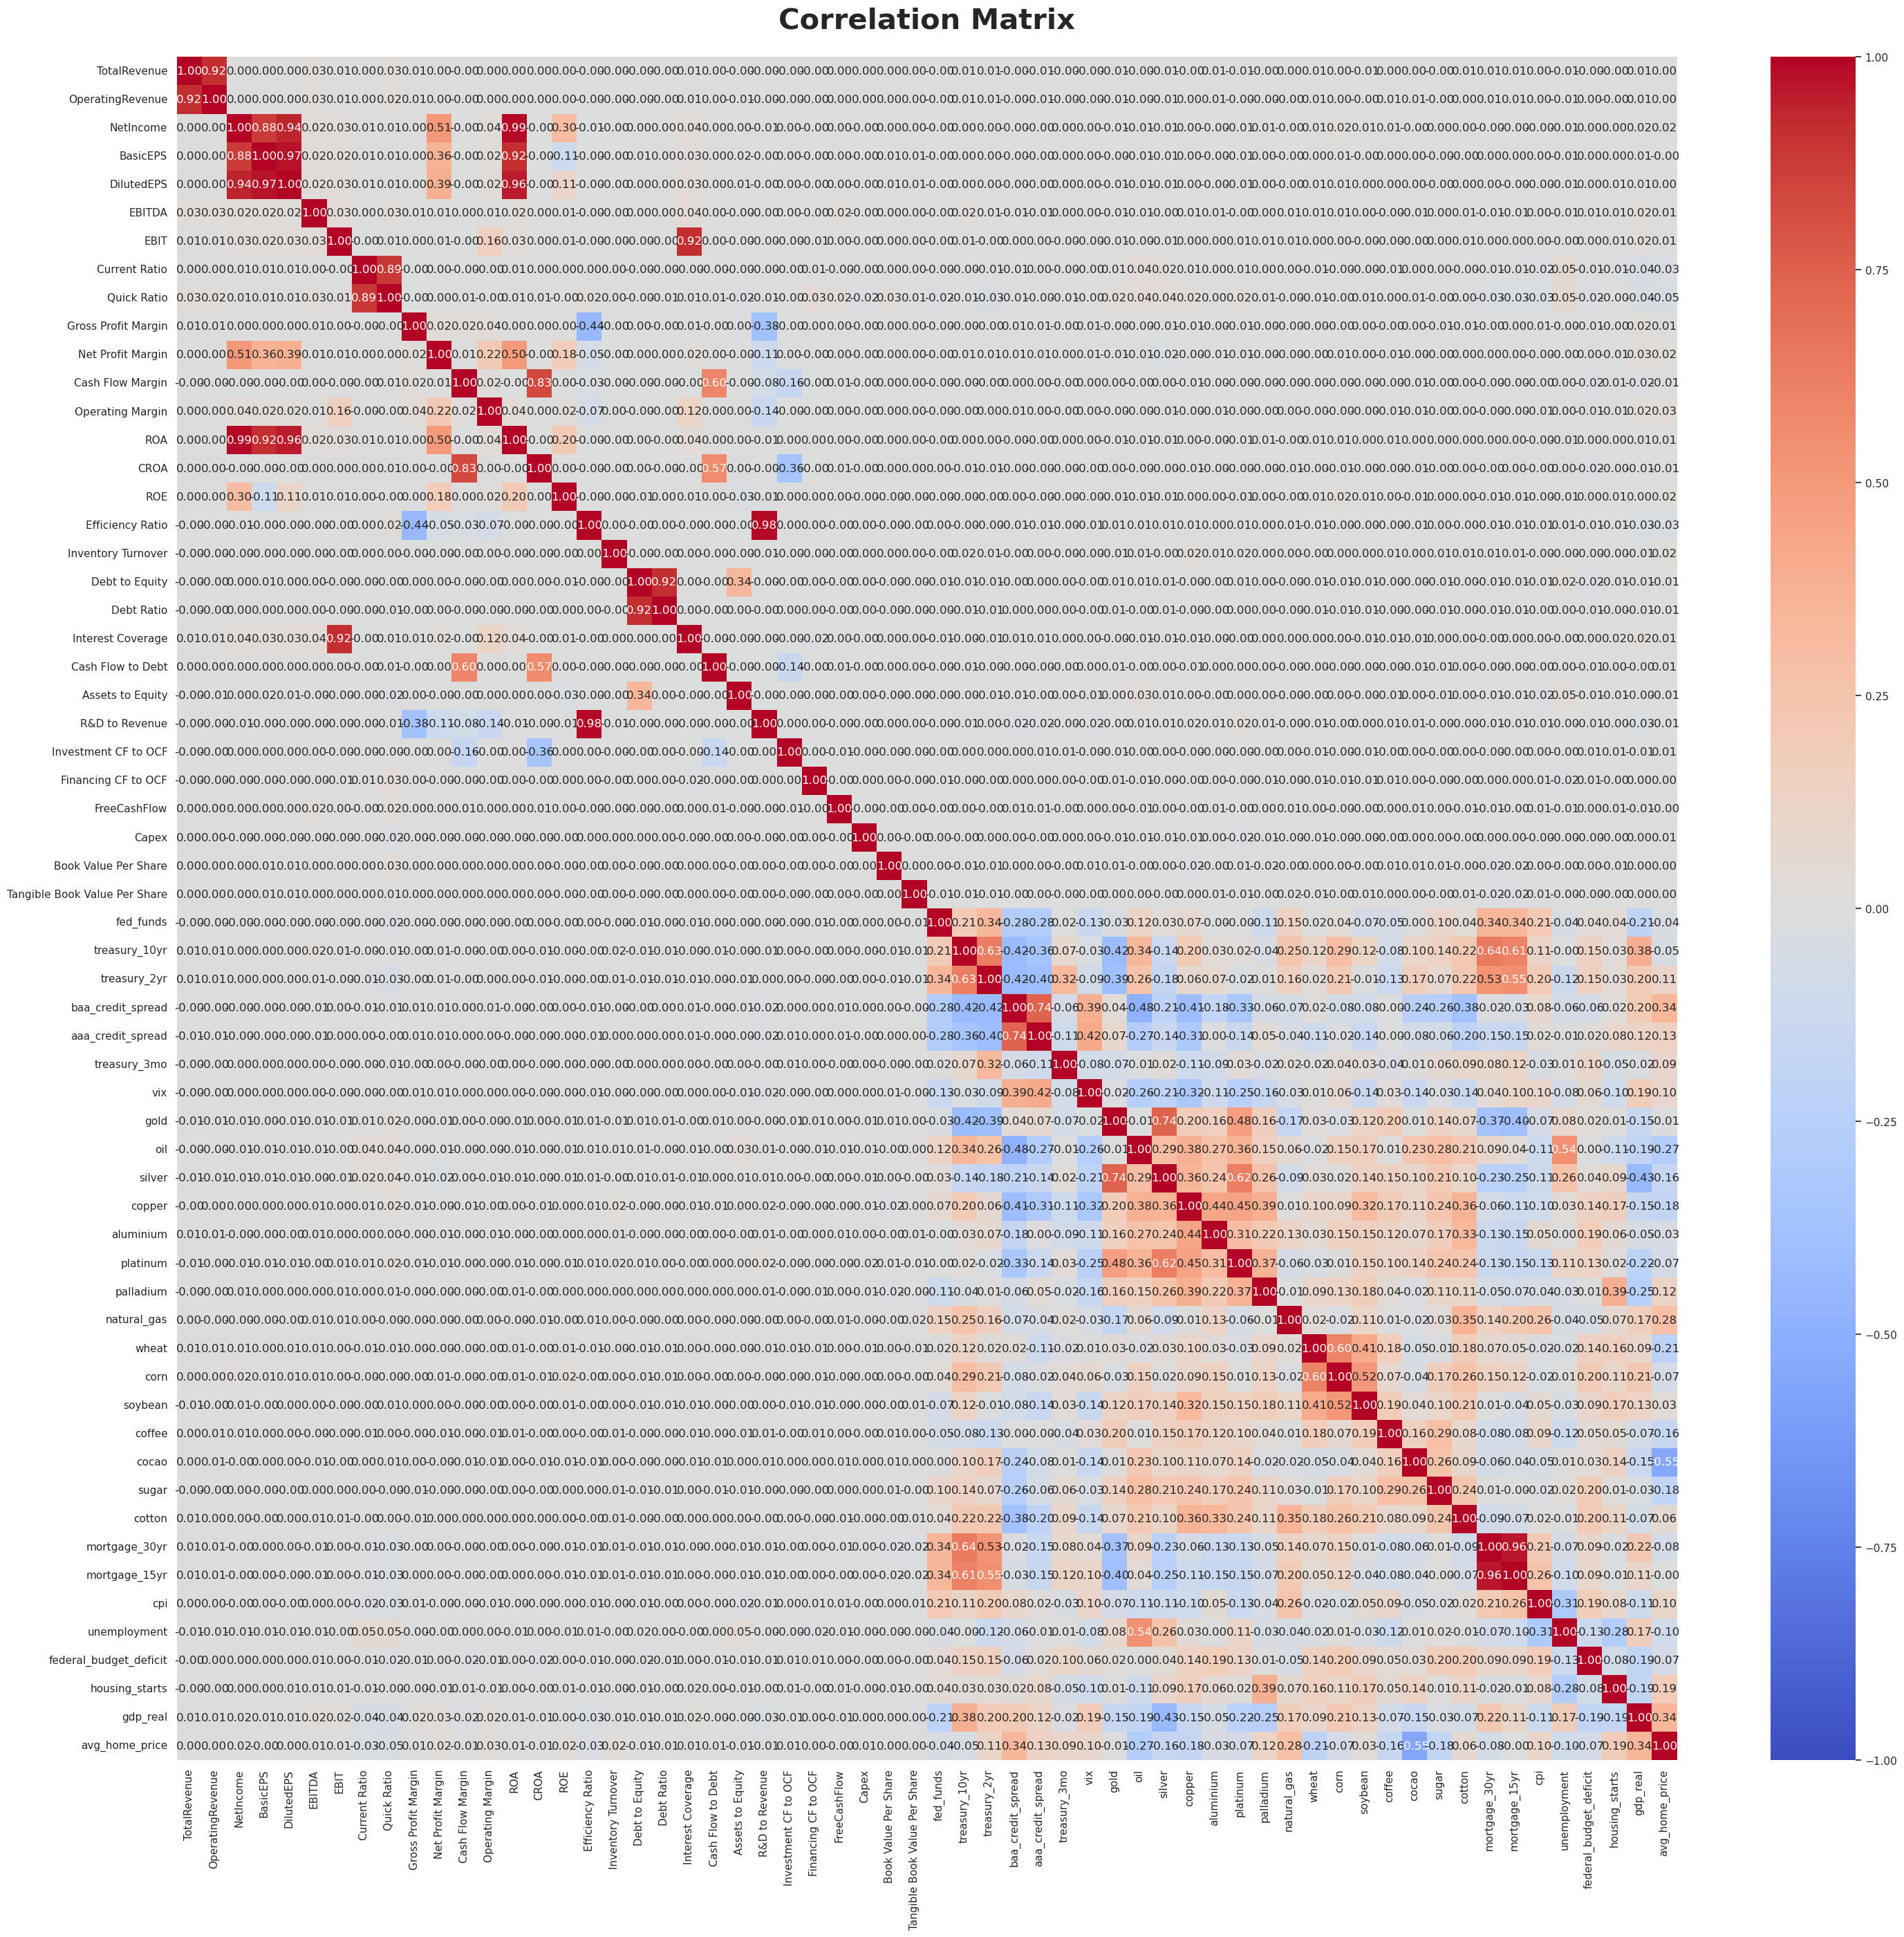

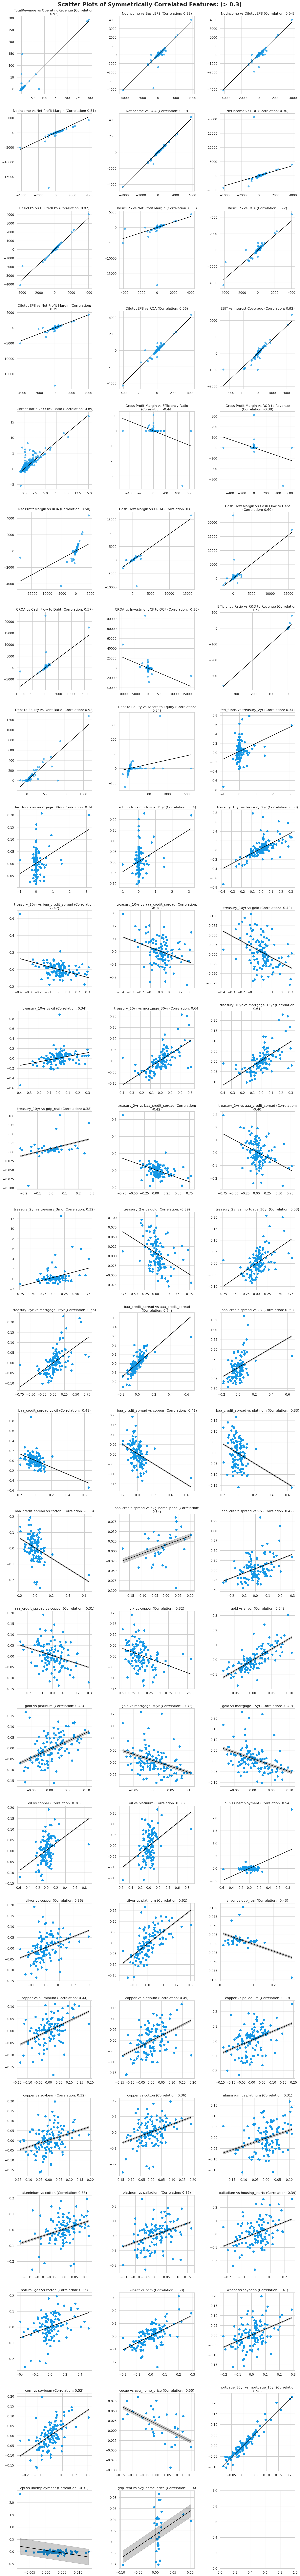



Asymmetrically Correlated Features: None with correlation >= 0.3.


In [5]:
utils.plot.correlation_matrix(df[features], sort=False, lower_bound=0.3)

The negative correlation between Cocao and the average home price is interesting, there likely isn't a direct relationship between the two but this relationship could cause some issues in the model. I'll remove cocao as there are several other agricultural commodities that are less problematic.

With the exception of a single outlier, Basic EPS and Diluted EPS are practically identical, I'll drop the latter for now.

The 15 year and 30 year bond yields are also highly correlated, this will be replaced by their difference as "30yr-15yr Mortgage Spread", the same for the BAA and AAA corporate bond spreads as "AAA-BAA Corporate Spread". These are both better indicators of the market's perception of credit riskiness (in real-estate and corporate dealings respectively) and the economy's health, as higher spreads may indicate higher risk and lower confidence in the overall economy. I should note that the AAA and BAA features are themselves a spread from the 10 year treasury yield, however, since we are interested in the spread between the two corporate rates this will have no impact on the scale nor interpretation of the new feature.

The 10yr and 2yr treasury yields have a decent fit, although not as good as the mortgages and bonds, nonetheless, this will be replaced by their difference as "10yr-2yr Treasury Spread". This is a better indicator of the market's perception of the economy's health, as a higher spread may indicate higher risk and lower confidence in the overall economy.

In [6]:
# Drop Cocao
df.drop(columns=['cocao'], inplace=True)

# Drop Diluted EPS
df.drop(columns=['DilutedEPS'], inplace=True)

# Replace 30yr and 15yr mortgage rates with their spread
df['30yr-15yr Mortgage Rate Spread'] = df['mortgage_30yr'] - df['mortgage_15yr']
df.drop(columns=['mortgage_30yr', 'mortgage_15yr'], inplace=True)

# Replace BAA and AAA corporate bond yields with their spread
df['BAA-AAA Corporate Bond Spread'] = df['baa_credit_spread'] - \
    df['aaa_credit_spread']
df.drop(columns=['baa_credit_spread', 'aaa_credit_spread'], inplace=True)

# Replace 10yr and 2yr treasury with their spread
df['10yr-2yr Treasury Spread'] = df['treasury_10yr'] - df['treasury_2yr']
df.drop(columns=['treasury_10yr', 'treasury_2yr'], inplace=True)

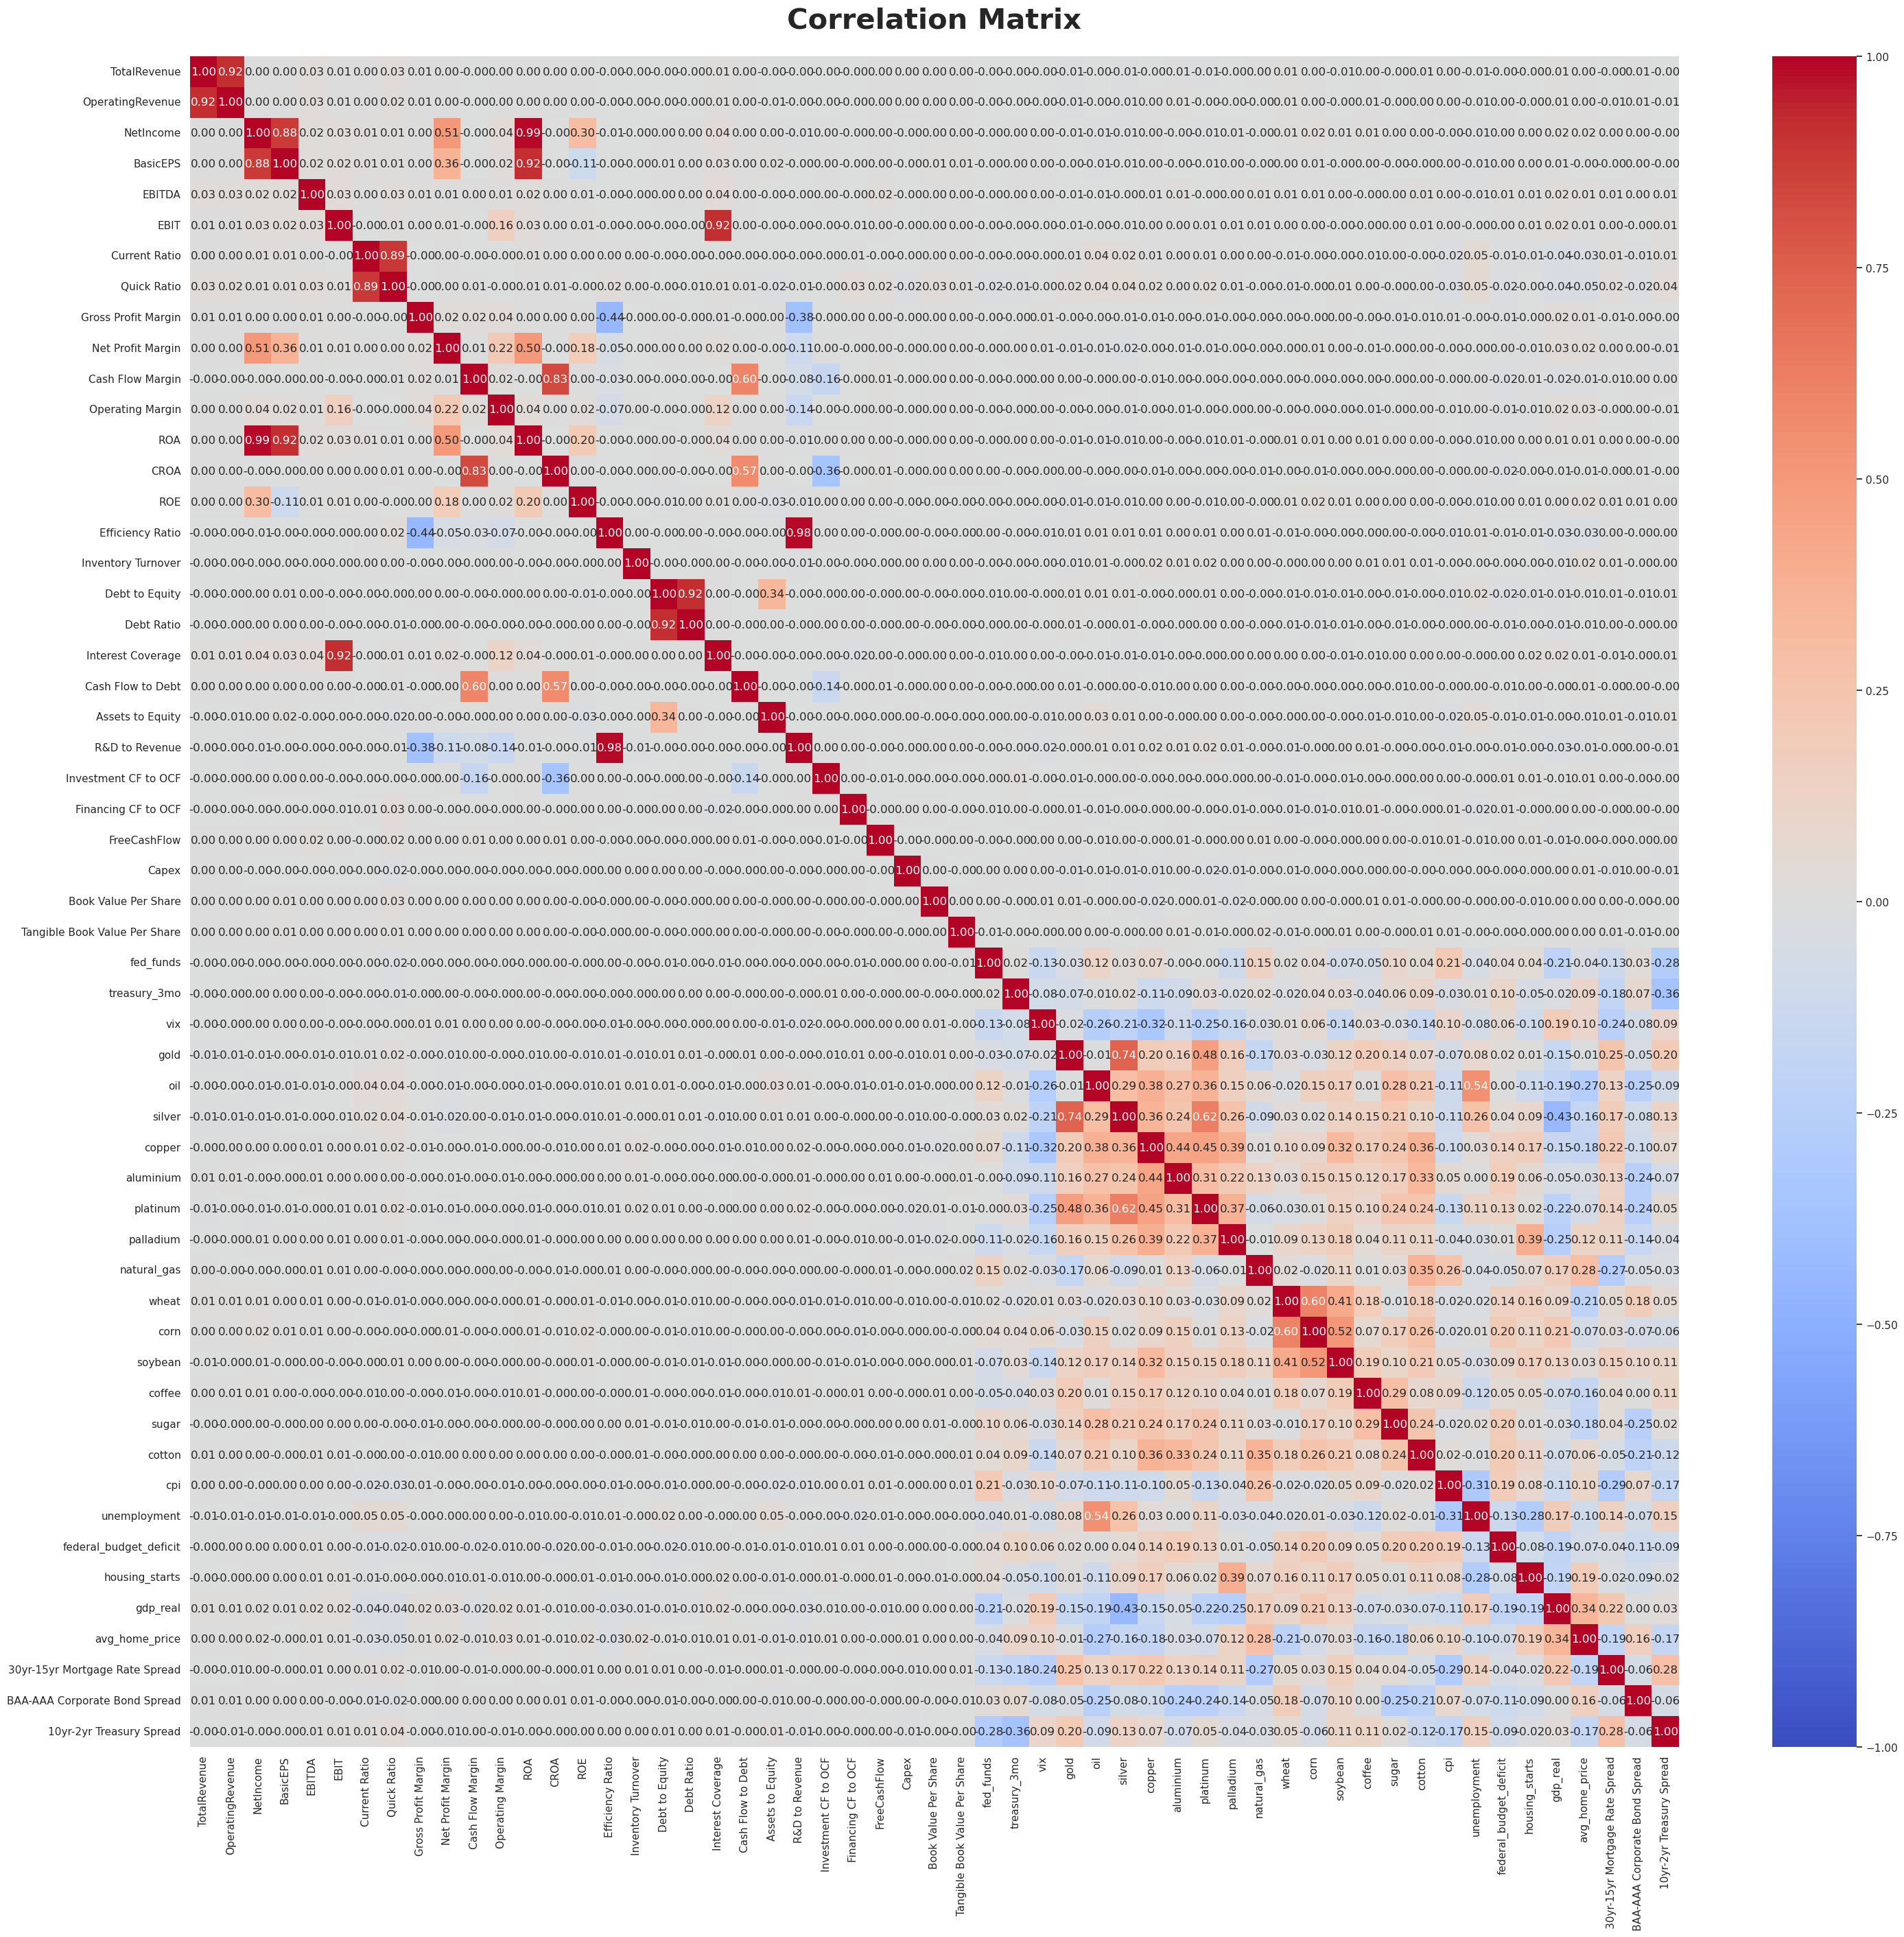

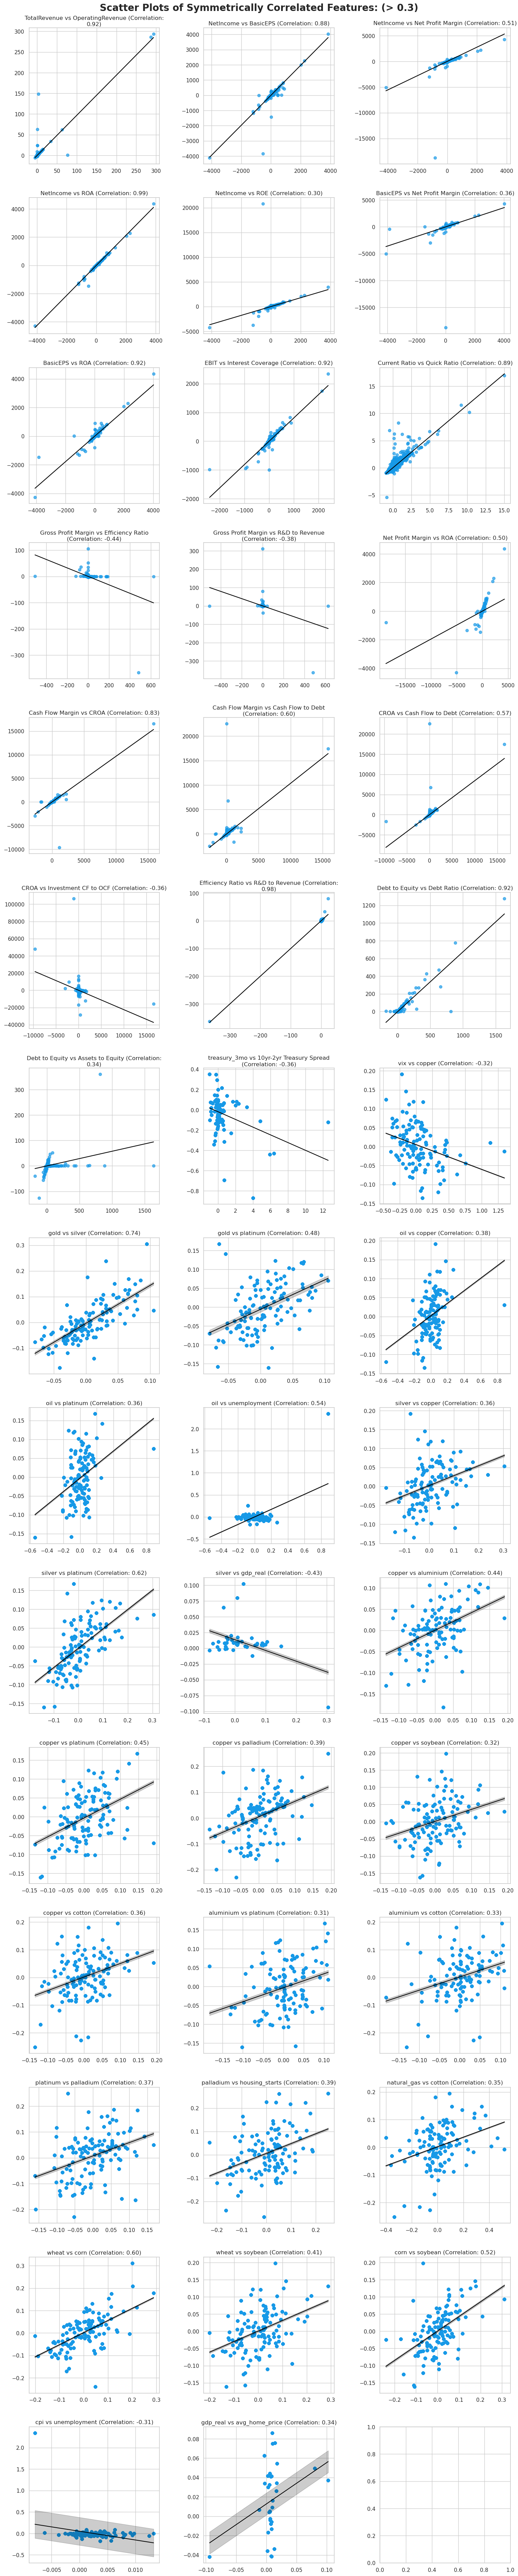



Asymmetrically Correlated Features: None with correlation >= 0.3.


In [7]:
# Rerun the correlation matrix
features, _ = get_features(df)
utils.plot.correlation_matrix(df[features], sort=False, lower_bound=0.3)

We have significantly decreased the amount of highly correlated features in the dataset, however there are still some problems to address.

Net Income and many of its derived features are highly correlated with each other, (BasicEPS, Net Profit Margin, ROA, ROE). Comparing different models with different subsets of these features may be the best solution.

Operating Cash Flow derived features are in a similar situation as they are all derived from Operating Cash Flow (Cash Flow Margin, Cash Return on Assets, Cash Flow to Debt).

EBIT and Interest Coverage are highly correlated with one another, considering that EBIT is used to calculate the Interest Coverage Ratio, this isn't surprising.

The current ratio and quick ratio are highly correlated with one another.

Debt to Equity, Debt Ratio, and Debt to Assets are others to look out for.

Gold, silver, and platinum are quite correlated with one another, as precious metals they generally move together. Copper and aluminium have a somewhat moderate correlation and given their similarity using both may cause issues. Palladium is of some concern however given its weak correlation with other metals, high residual varaiblity, and different use cases it will be left alone.

Wheat, corn, and soybeans may cause some issues with moderate correlations as major agricultural products, these generally move together.

#### Variance Inflation Factor (VIF)

is a measure used in regression analysis to quantify the extent of multicollinearity among predictor variables in a regression model. The VIF measures how much the variance of the estimated regression coefficients is inflated due to multicollinearity. Specifically, it assesses how much the variance of the estimated coefficient of a predictor variable is increased compared to when that variable is not correlated with the other predictor variables in the model.

A high VIF indicates that the variance of the estimated coefficient of the predictor variable is greatly inflated due to multicollinearity, making the interpretation of the coefficient unreliable.

 A VIF of 1 indicates that the features are not correlated, while a VIF of 5-10 indicates moderate correlation, and a VIF of 10+ indicates high correlation between the features.

In [8]:
# VIF of features
utils.stats.vif(df[features])

Features         VIF
3                        NetIncome  211.338651
13                             ROA  206.613703
18                  Debt to Equity   23.304690
19                      Debt Ratio   20.614777
4                         BasicEPS   12.731862
2                 OperatingRevenue    6.427814
1                     TotalRevenue    6.427674
15                             ROE    4.843324
14                            CROA    4.005906
35                          silver    3.888404
11                Cash Flow Margin    3.831877
22                Assets to Equity    3.638097
33                            gold    3.187971
34                             oil    2.615910
6                             EBIT    2.520553
20               Interest Coverage    2.487506
42                            corn    2.467153
38                        platinum    2.355610
16                Efficiency Ratio    2.217140
36                          copper    2.193343
48                    unemployment    2.109977
23                  R&D to Revenue    2.095165
41                           wheat    1.956030
43                         soybean    1.912176
46                          cotton    1.782061
55        10yr-2yr Treasury Spread    1.654097
39                       palladium    1.653911
40                     natural_gas    1.639048
21               Cash Flow to Debt    1.599569
53  30yr-15yr Mortgage Rate Spread    1.577608
10               Net Profit Margin    1.544848
50                  housing_starts    1.512926
37                       aluminium    1.487023
54   BAA-AAA Corporate Bond Spread    1.453823
51                        gdp_real    1.430102
32                             vix    1.421252
47                             cpi    1.418517
45                           sugar    1.414763
30                       fed_funds    1.335225
31                    treasury_3mo    1.324261
52                  avg_home_price    1.324252
44                          coffee    1.276259
9              Gross Profit Margin    1.242127
24            Investment CF to OCF    1.228002
49          federal_budget_deficit    1.219868
12                Operating Margin    1.102478
8                      Quick Ratio    1.036104
7                    Current Ratio    1.032724
5                           EBITDA    1.004334
26                    FreeCashFlow    1.001380
25             Financing CF to OCF    1.001376
28            Book Value Per Share    1.001280
29   Tangible Book Value Per Share    1.001275
27                           Capex    1.000221
17              Inventory Turnover    1.000212

Unsurprisingly, the VIFs for the Net Income derived features are all very high, which is expected given their high correlation with one another as identified earlier. Although, the VIFs for the Operating Cash Flow derived features are lower than expected, this may be due to outliers.

Further tuning of the dataset is required to address multicollinearity, and the best approach will be to compare different models with different subsets to see which ones are the most important for predicting equity valuations within a given sector.

### Target Distribution

The distribution of the target variable (stock return) can be very important for predictive models. If the target is not normally distributed, it may be necessary to transform it to a normal distribution. This is especially important for linear regression models, which assume that the residuals are normally distributed.

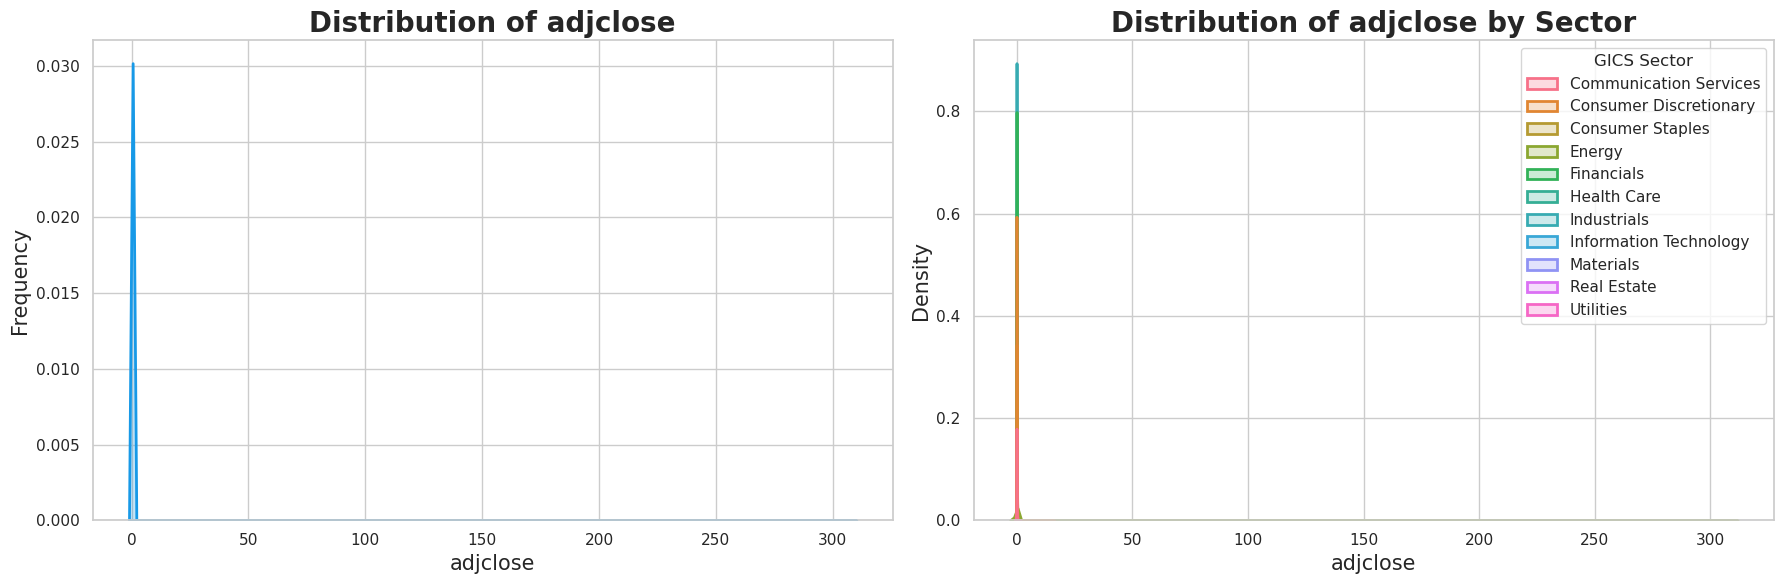

In [9]:
def plot_dist_sector(df: pd.DataFrame, key: str, log_scale_x: bool = False, log_scale_y: bool = False):
    _, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot distribution of target variable
    sns.kdeplot(df[key], color=PRIMARY_COLOR, fill=True, linewidth=2, ax=axes[0])
    axes[0].set_title(f'Distribution of {key}', fontsize=20, fontweight='bold')
    axes[0].set_xlabel(key, fontsize=15)
    axes[0].set_ylabel('Frequency', fontsize=15)
    if log_scale_x:
        axes[0].set_xscale('log')
    if log_scale_y:
        axes[0].set_yscale('log')

    # Plot distribution of target variable by sector
    sns.kdeplot(data=df, x=key, hue='GICS Sector', fill=True, linewidth=2, ax=axes[1])
    axes[1].set_title(f'Distribution of {key} by Sector', fontsize=20, fontweight='bold')
    axes[1].set_xlabel(key, fontsize=15)
    axes[1].set_ylabel('Density', fontsize=15)  # Change ylabel to 'Density' for KDE plot
    if log_scale_x:
        axes[1].set_xscale('log')
    if log_scale_y:
        axes[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

plot_dist_sector(df, target)

The distribution is clearly not normal for the target, with an extreme right skew. There appears to be some extreme outliers in the positive direction, driving the malority of the skew. This is likely caused by positive news events. It's also important to note that a stock price can have more than a 100% upside potential, but not more than a 100% downside potential (except in rare special cirumstances, none of which are in this dataset).

In [10]:
# Display adjusted close > 300
display(df.query(f'`{target}` > 300'))

symbol  cap GICS Sector ID GICS Sector GICS Industry Group ID  \
28350   CHRD  mid             10      Energy                   1010   

      GICS Industry Group GICS Industry ID                GICS Industry  \
28350              Energy         101020.0  Oil, Gas & Consumable Fuels   

      GICS Sub-Industry ID                   GICS Sub-Industry       date  \
28350           10102020.0  Oil & Gas Exploration & Production 2020-11-30   

         adjclose  TotalRevenue  OperatingRevenue  NetIncome  BasicEPS  \
28350  309.909088           NaN               NaN        NaN       NaN   

       EBITDA  EBIT  Current Ratio  Quick Ratio  Gross Profit Margin  \
28350     NaN   NaN            NaN          NaN                  NaN   

       Net Profit Margin  Cash Flow Margin  Operating Margin  ROA  CROA  ROE  \
28350                NaN               NaN               NaN  NaN   NaN  NaN   

       Efficiency Ratio  Inventory Turnover  Debt to Equity  Debt Ratio  \
28350               NaN                 NaN             NaN         NaN   

       Interest Coverage  Cash Flow to Debt  Assets to Equity  R&D to Revenue  \
28350                NaN                NaN               NaN             NaN   

       Investment CF to OCF  Financing CF to OCF  FreeCashFlow  Capex  \
28350                   NaN                  NaN           NaN    NaN   

       Book Value Per Share  Tangible Book Value Per Share  fed_funds  \
28350                   NaN                            NaN        0.0   

       treasury_3mo       vix      gold       oil    silver    copper  \
28350     -0.096385 -0.458969 -0.054171  0.266834 -0.045857  0.123871   

       aluminium  platinum  palladium  natural_gas     wheat      corn  \
28350   0.109002  0.141487   0.082568    -0.140728 -0.030493  0.053325   

       soybean   coffee     sugar    cotton       cpi  unemployment  \
28350  0.10601  0.15613  0.010446  0.024231  0.000446     -0.126582   

       federal_budget_deficit  housing_starts  gdp_real  avg_home_price  \
28350               -1.279659        0.081272       NaN             NaN   

       30yr-15yr Mortgage Rate Spread  BAA-AAA Corporate Bond Spread  \
28350                       -0.014787                      -0.023268   

       10yr-2yr Treasury Spread  
28350                 -0.188312

CHRD (Chord Energy Corp, formerly Oasis Petroleum, merged with Whiting Petroleum in 2022) is the most glaring outlier. It filed for a bankruptcy prematurely in mid 2020, and emerged from bankruptcy in November 2020. This special case will be removed from the dataset from prior to December 2020.

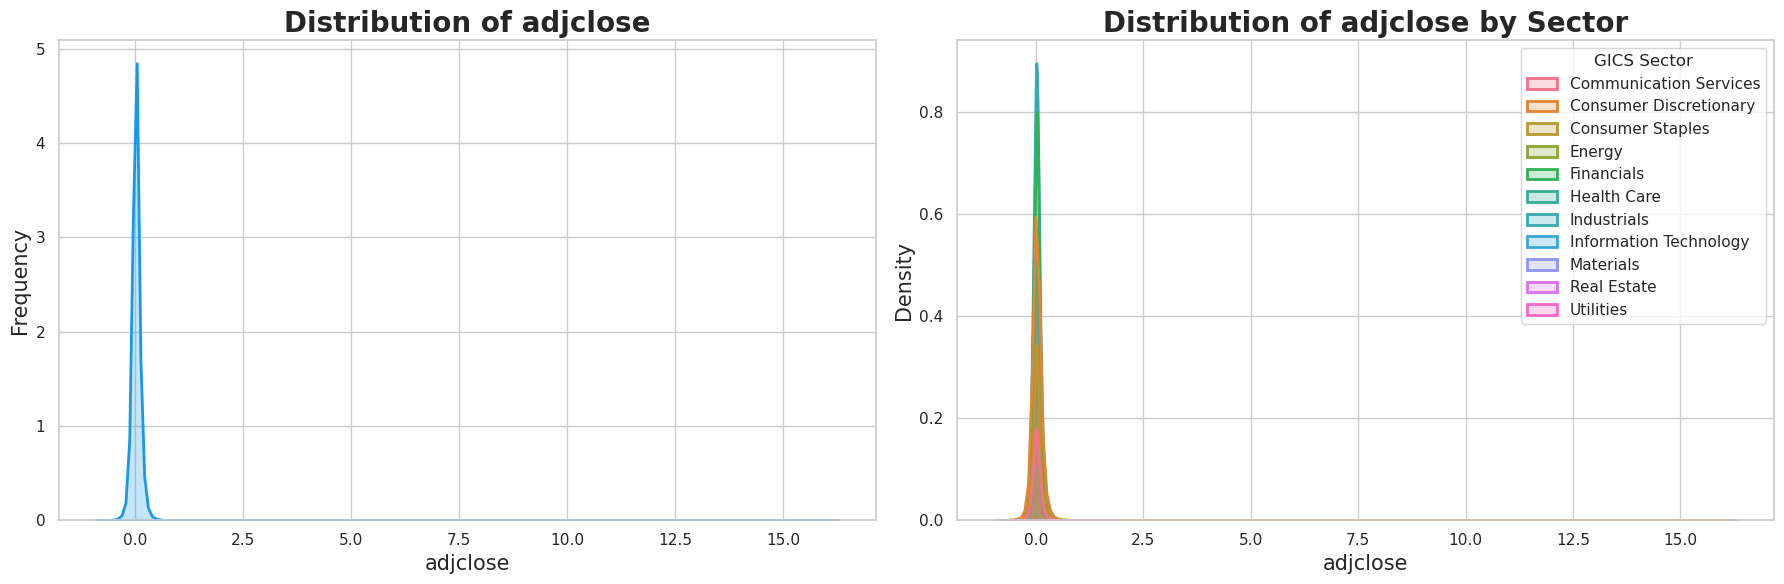

In [11]:
# Remove CHRD prior to December 2020
df = df.query('not (symbol == "CHRD" and date < "2020-12-01")')

plot_dist_sector(df, target)

The right tail of the distribution appears to still have possible outliers (> 5 or 500%)

In [12]:
display(df.query(f'`{target}` > 5').head(15))

symbol  cap GICS Sector ID             GICS Sector  \
59342    GME  mid             25  Consumer Discretionary   

      GICS Industry Group ID                           GICS Industry Group  \
59342                   2550  Consumer Discretionary Distribution & Retail   

      GICS Industry ID     GICS Industry GICS Sub-Industry ID  \
59342         255040.0  Specialty Retail           25504020.0   

                   GICS Sub-Industry       date  adjclose  TotalRevenue  \
59342  Computer & Electronics Retail 2021-01-29  16.25053           NaN   

       OperatingRevenue  NetIncome  BasicEPS  EBITDA  EBIT  Current Ratio  \
59342               NaN        NaN       NaN     NaN   NaN            NaN   

       Quick Ratio  Gross Profit Margin  Net Profit Margin  Cash Flow Margin  \
59342          NaN                  NaN                NaN               NaN   

       Operating Margin  ROA  CROA  ROE  Efficiency Ratio  Inventory Turnover  \
59342               NaN  NaN   NaN  NaN               NaN                 NaN   

       Debt to Equity  Debt Ratio  Interest Coverage  Cash Flow to Debt  \
59342             NaN         NaN                NaN                NaN   

       Assets to Equity  R&D to Revenue  Investment CF to OCF  \
59342               NaN             NaN                   NaN   

       Financing CF to OCF  FreeCashFlow  Capex  Book Value Per Share  \
59342                  NaN           NaN    NaN                   NaN   

       Tangible Book Value Per Share  fed_funds  treasury_3mo       vix  \
59342                            NaN  -0.222222     -0.261538  0.454506   

           gold       oil    silver    copper  aluminium  platinum  palladium  \
59342 -0.024193  0.075845  0.021571  0.016932   -0.00402  0.000093  -0.058526   

       natural_gas     wheat      corn   soybean    coffee    sugar    cotton  \
59342     0.009846  0.035129  0.130165  0.041627 -0.041326  0.02195  0.032258   

            cpi  unemployment  federal_budget_deficit  housing_starts  \
59342  0.003673           0.0                 0.01173        0.078862   

       gdp_real  avg_home_price  30yr-15yr Mortgage Rate Spread  \
59342  0.010565        0.016279                        0.008647   

       BAA-AAA Corporate Bond Spread  10yr-2yr Treasury Spread  
59342                       -0.08151                  0.347395

Throughout early 2021, GME (GameStop) experienced a short squeeze and significant media hype, which caused the stock price to skyrocket. This special case will be removed from the dataset through Q3 2021.

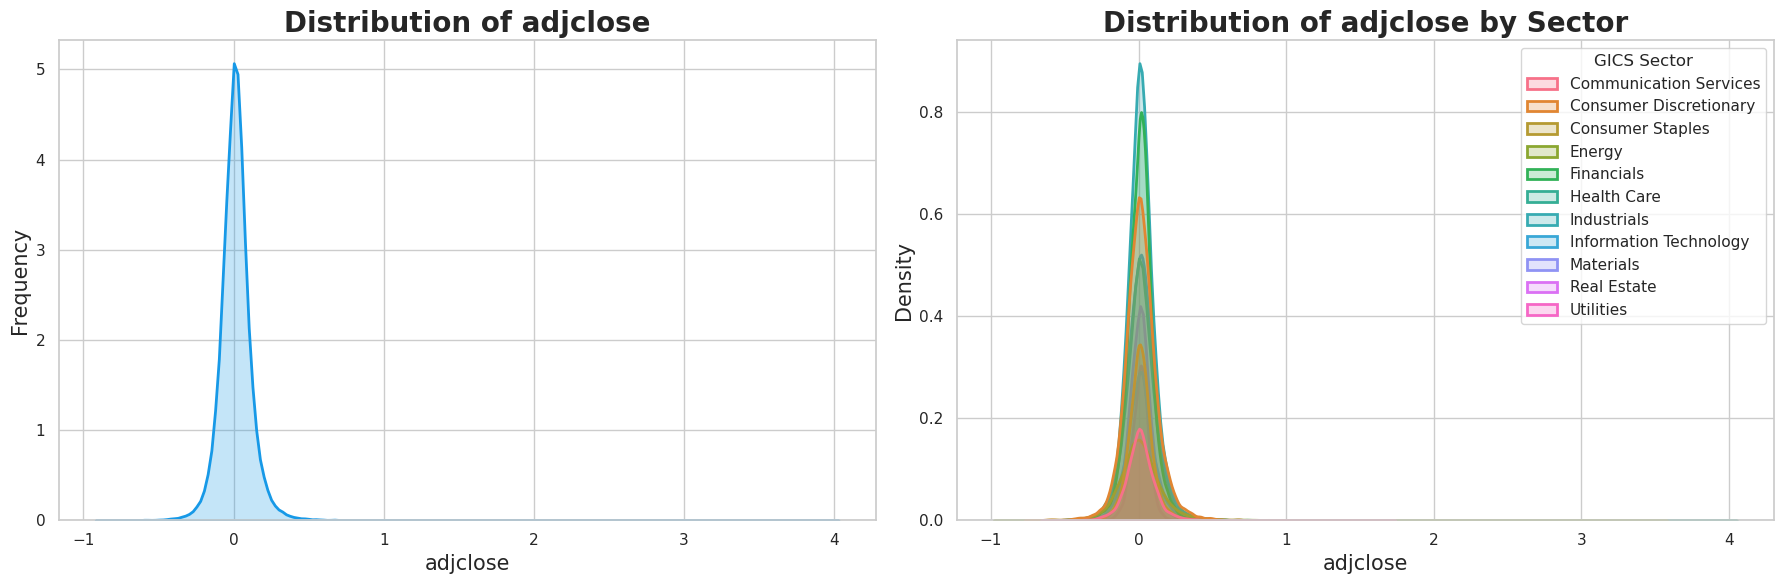

In [13]:
# Remove GME through Q3 2021
df = df.query('not (symbol == "GME" and date < "2021-10-01")')

plot_dist_sector(df, target)

In [14]:
# Take a look at target > 2 (200%)
display(df.query(f'`{target}` > 2').head(15))

symbol    cap GICS Sector ID  GICS Sector GICS Industry Group ID  \
7836     AMEH  small             35  Health Care                   3510   
10292     APA  large             10       Energy                   1010   
11205      AR    mid             10       Energy                   1010   
39653     DDD  small             20  Industrials                   2010   
107632   PECO  small             60  Real Estate                   6010   
112254     PR    mid             10       Energy                   1010   
125934     SM  small             10       Energy                   1010   

                                 GICS Industry Group GICS Industry ID  \
7836                Health Care Equipment & Services         351020.0   
10292                                         Energy         101020.0   
11205                                         Energy         101020.0   
39653                                  Capital Goods         201060.0   
107632  Equity Real Estate Investment Trusts (REITs)         601070.0   
112254                                        Energy         101020.0   
125934                                        Energy         101020.0   

                           GICS Industry GICS Sub-Industry ID  \
7836    Health Care Providers & Services           35102020.0   
10292        Oil, Gas & Consumable Fuels           10102020.0   
11205        Oil, Gas & Consumable Fuels           10102020.0   
39653                          Machinery           20106020.0   
107632                      Retail REITs           60107010.0   
112254       Oil, Gas & Consumable Fuels           10102020.0   
125934       Oil, Gas & Consumable Fuels           10102020.0   

                                   GICS Sub-Industry       date  adjclose  \
7836                          Health Care Facilities 2016-12-30  4.000000   
10292             Oil & Gas Exploration & Production 2020-04-30  2.138439   
11205             Oil & Gas Exploration & Production 2020-04-30  3.197183   
39653   Industrial Machinery & Supplies & Components 2021-01-29  2.391222   
107632                                  Retail REITs 2021-07-30  2.872752   
112254            Oil & Gas Exploration & Production 2020-04-30  3.486691   
125934            Oil & Gas Exploration & Production 2020-04-30  2.339550   

        TotalRevenue  OperatingRevenue  NetIncome  BasicEPS    EBITDA  \
7836             NaN               NaN        NaN       NaN       NaN   
10292            NaN               NaN        NaN       NaN       NaN   
11205      -0.193111         -0.193111    0.29736  0.260870  0.432724   
39653            NaN               NaN        NaN       NaN       NaN   
107632           NaN               NaN        NaN       NaN       NaN   
112254           NaN               NaN        NaN       NaN       NaN   
125934     -0.211490         -0.211064   -3.03601 -3.044445 -2.688065   

            EBIT  Current Ratio  Quick Ratio  Gross Profit Margin  \
7836         NaN            NaN          NaN                  NaN   
10292        NaN            NaN          NaN                  NaN   
11205   0.260933       0.298853          NaN            -3.269207   
39653        NaN            NaN          NaN                  NaN   
107632       NaN            NaN          NaN                  NaN   
112254       NaN            NaN          NaN                  NaN   
125934 -4.282960       2.046193          NaN            -0.964139   

        Net Profit Margin  Cash Flow Margin  Operating Margin       ROA  \
7836                  NaN               NaN               NaN       NaN   
10292                 NaN               NaN               NaN       NaN   
11205            0.129199          0.681118        -30.713179  0.264865   
39653                 NaN               NaN               NaN       NaN   
107632                NaN               NaN               NaN       NaN   
112254                NaN               NaN               NaN       NaN   
125934          -4.1

PECO (Phillips Edison & Company) didn't IPO until July 2021 and the price chart prior to this time is off, this special case will be removed from the dataset.

AMEH (Apollo Medical Holdings), the most extreme outlier in the dataset, had very promising guidance in late 2016, unfortunately, this kind of news is not present in the dataset. This is something to keep in mind for future work.

APA, AR, SM, PR, all in the Oil and Gas sector, experienced a significant increase in stock price in April 2020 despite several reporting a decrease in revenue. The pop is due to an oil discovery located off the coast of Suriname, while the revenue decrease is mostly a result of the COVID-19 pandemic. I'll revisit removing this event from the dataset during the Energy Sector's analysis.

Distribution without target > 2 (200%)


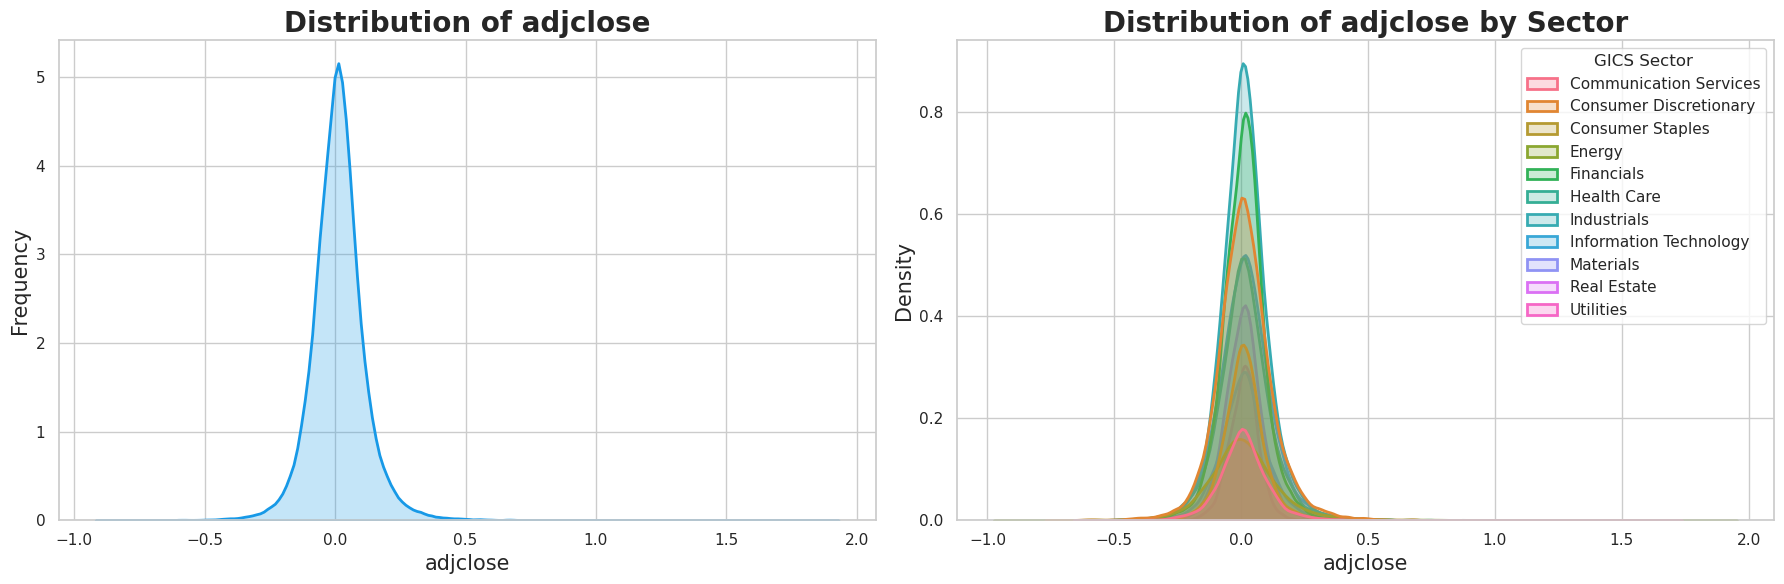

In [15]:
# Remove PECO until August 2021
df = df.query('not (symbol == "PECO" and date < "2021-08-01")')

# Plot dist without these outliers
print('Distribution without target > 2 (200%)')
plot_dist_sector(df.query(f'not {target} > 2'), target)

Without these outliers, the distribution is still right skewed, but not as extreme. Winsorizing the target variable on a per sector basis may be a good idea.

In [16]:
# Display the bottom 15
display(df.nsmallest(15, target))

symbol    cap GICS Sector ID             GICS Sector  \
112253     PR    mid             10                  Energy   
10291     APA  large             10                  Energy   
125933     SM  small             10                  Energy   
136576   TRGP  large             10                  Energy   
95470     NBR  small             10                  Energy   
104905    OVV    mid             10                  Energy   
33538     CPE  small             10                  Energy   
65081     HLX  small             10                  Energy   
12058    ARWR    mid             35             Health Care   
102608    OIS  small             10                  Energy   
93442    MTDR    mid             10                  Energy   
101303   NYMT  small             40              Financials   
85036     MAC  small             60             Real Estate   
124291    SIG  small             25  Consumer Discretionary   
102492    OII  small             10                  Energy   

       GICS Industry Group ID                             GICS Industry Group  \
112253                   1010                                          Energy   
10291                    1010                                          Energy   
125933                   1010                                          Energy   
136576                   1010                                          Energy   
95470                    1010                                          Energy   
104905                   1010                                          Energy   
33538                    1010                                          Energy   
65081                    1010                                          Energy   
12058                    3520  Pharmaceuticals, Biotechnology & Life Sciences   
102608                   1010                                          Energy   
93442                    1010                                          Energy   
101303                   4020                              Financial Services   
85036                    6010    Equity Real Estate Investment Trusts (REITs)   
124291                   2550    Consumer Discretionary Distribution & Retail   
102492                   1010                                          Energy   

       GICS Industry ID                                   GICS Industry  \
112253         101020.0                     Oil, Gas & Consumable Fuels   
10291          101020.0                     Oil, Gas & Consumable Fuels   
125933         101020.0                     Oil, Gas & Consumable Fuels   
136576         101020.0                     Oil, Gas & Consumable Fuels   
95470          101010.0                     Energy Equipment & Services   
104905         101020.0                     Oil, Gas & Consumable Fuels   
33538          101020.0                     Oil, Gas & Consumable Fuels   
65081          101010.0                     Energy Equipment & Services   
12058          352010.0                                   Biotechnology   
102608         101010.0                     Energy Equipment & Services   
93442          101020.0                     Oil, Gas & Consumable Fuels   
101303         402040.0  Mortgage Real Estate Investment Trusts (REITs)   
85036          601070.0                                    Retail REITs   
124291         255040.0                                Specialty Retail   
102492         101010.0                     Energy Equipment & Services   

       GICS Sub-Industry ID                   GICS Sub-Industry       date  \
112253           10102020.0  Oil & Gas Exploration & Production 2020-03-31   
10291            10102020.0  Oil & Gas Exploration & Production 2020-03-31   
125933           10102020.0  Oil & Gas Exploration & Production 2020-03-31   
136576           10102040.0  Oil & Gas Storage & Transportation 2020-03-31   
95470            10101010.0                  Oil & Gas Drilling 2020-03-31   
104905           10102020.0  Oil

The bottom 15 are all March 2020, which isn't surprising due to the COVID-19 pandemic crash. Of those, the Energy Sector was hit the hardest due to the crash in oil prices. I suspect VIX will be an important feature for predicting some large fluctuations as an indicator of market volatility, typically a trailing indicator of market crashes.

### Economic Indicators

The values for economic indicators will be the same for each day in the dataset.

Feature: fed_funds


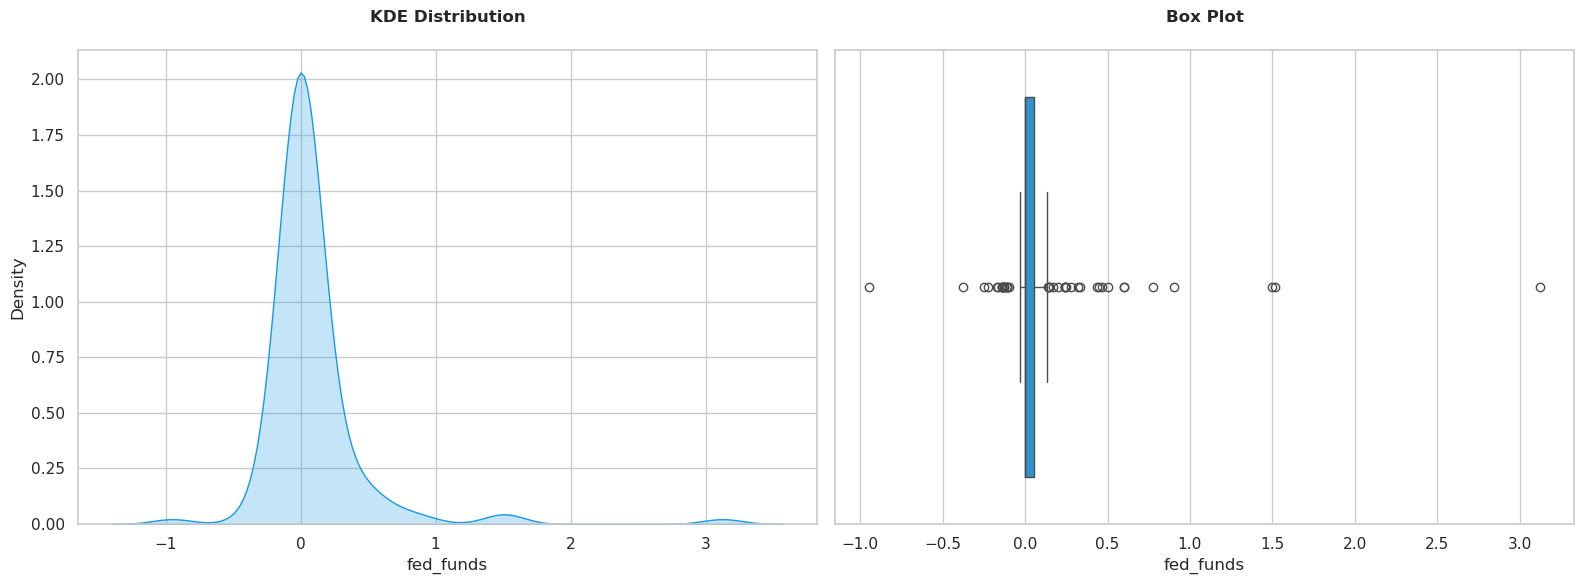

Feature: treasury_3mo


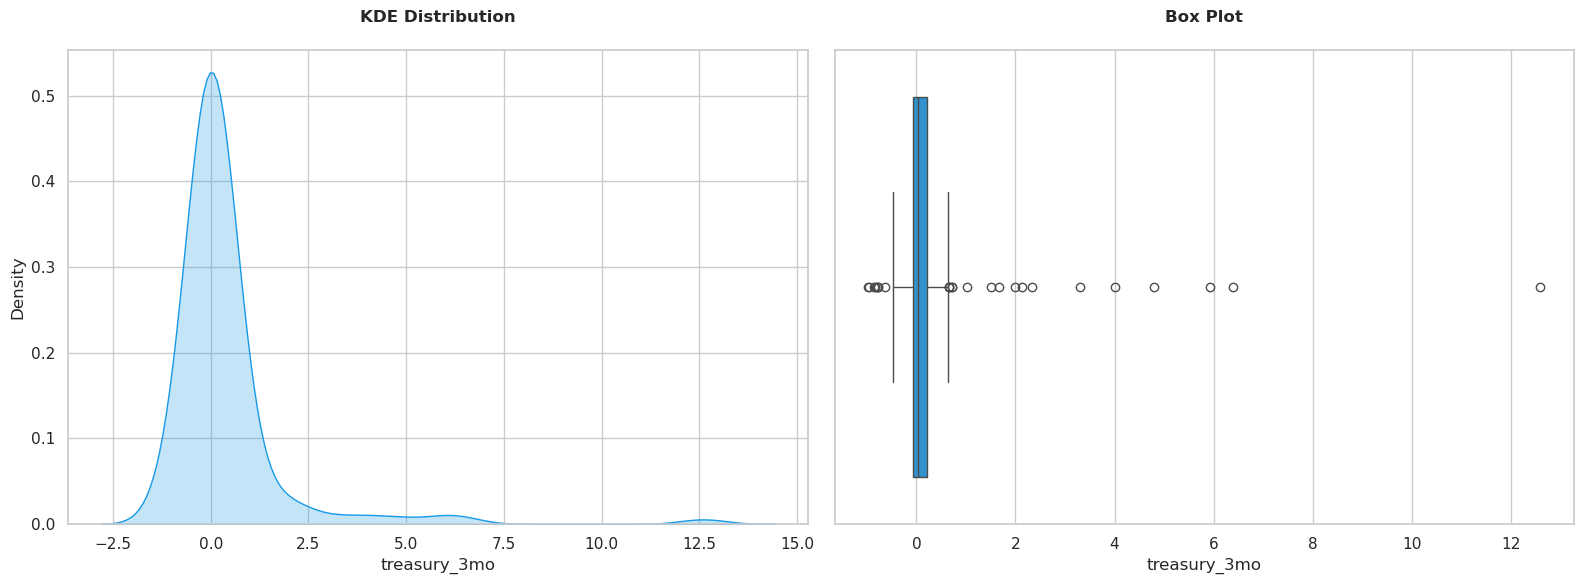

Feature: vix


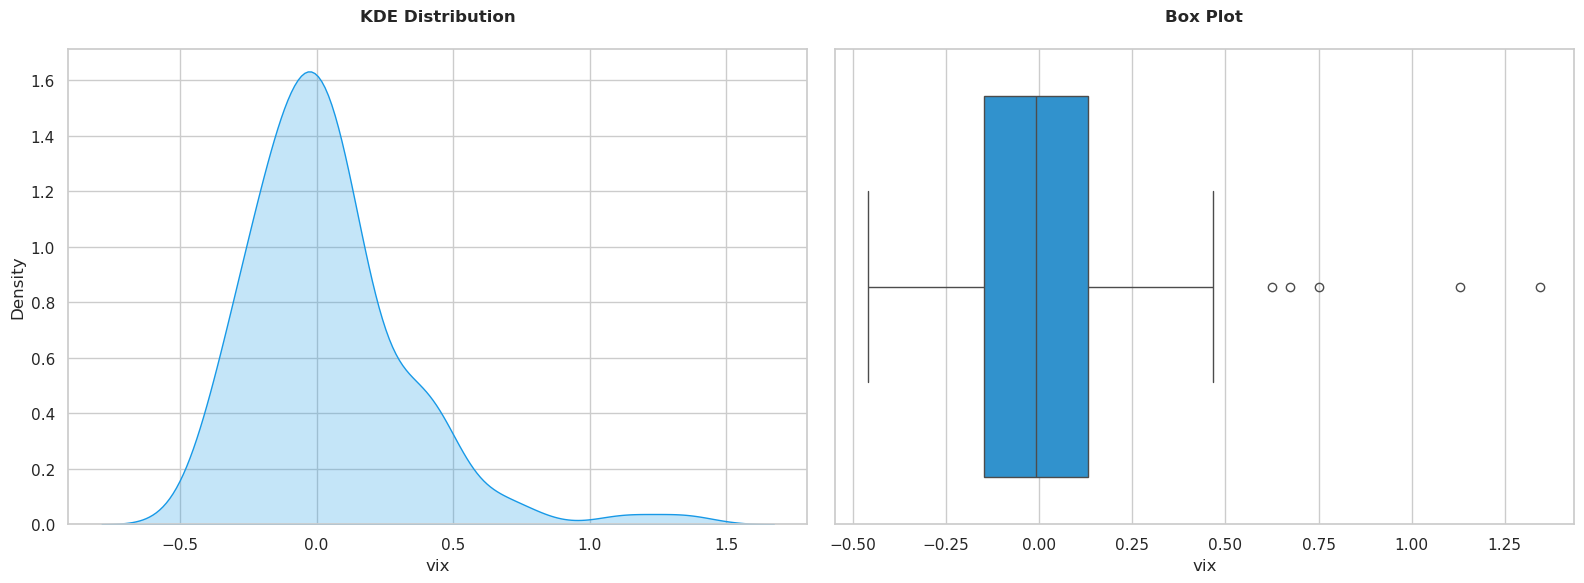

Feature: gold


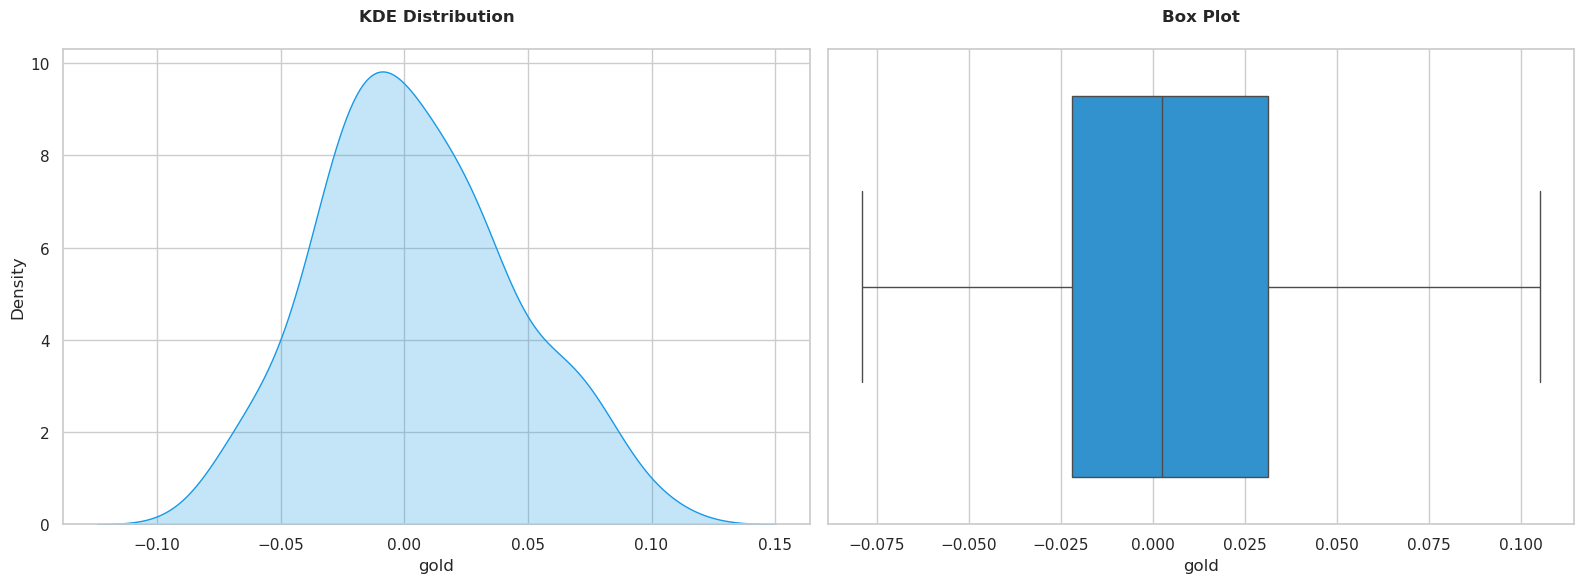

Feature: silver


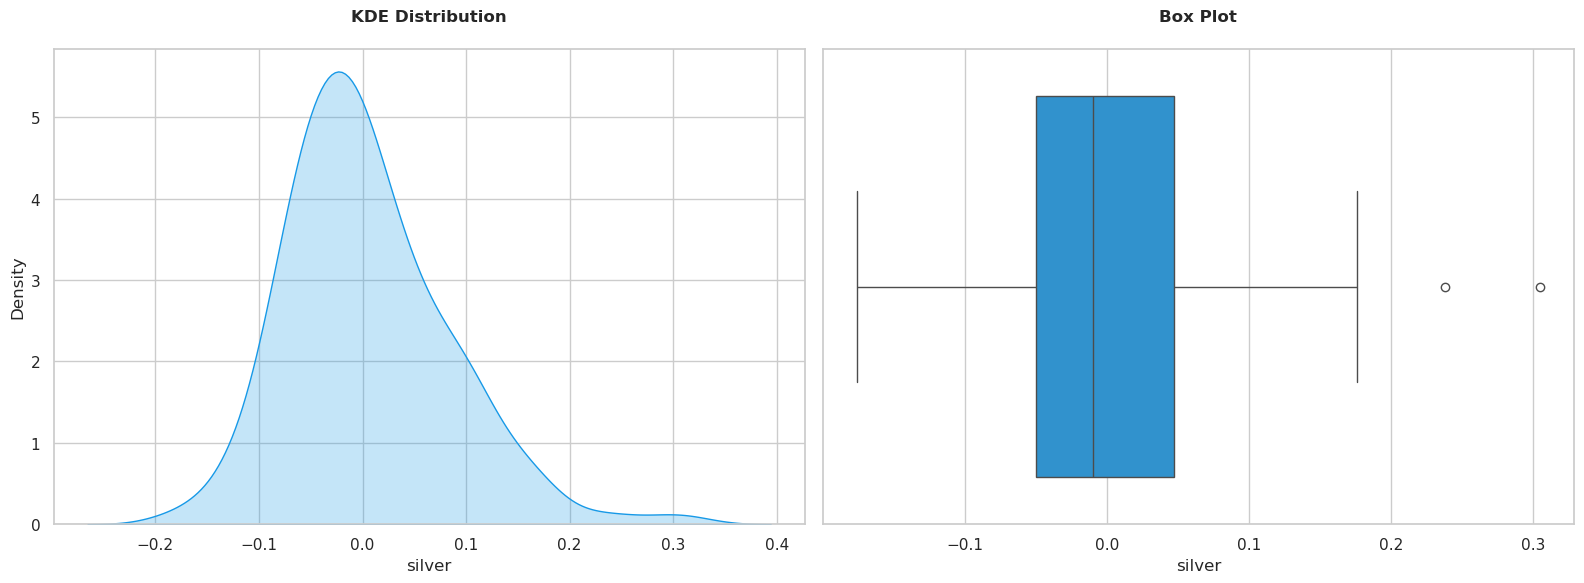

Feature: platinum


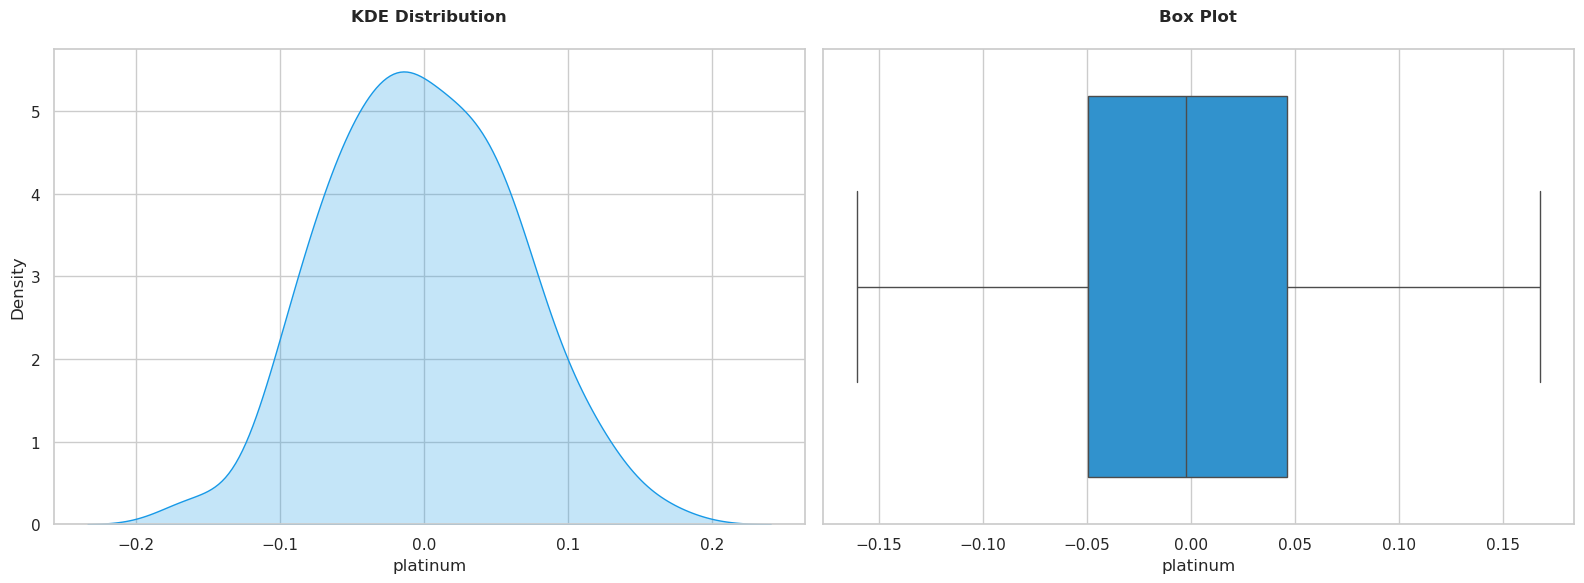

Feature: oil


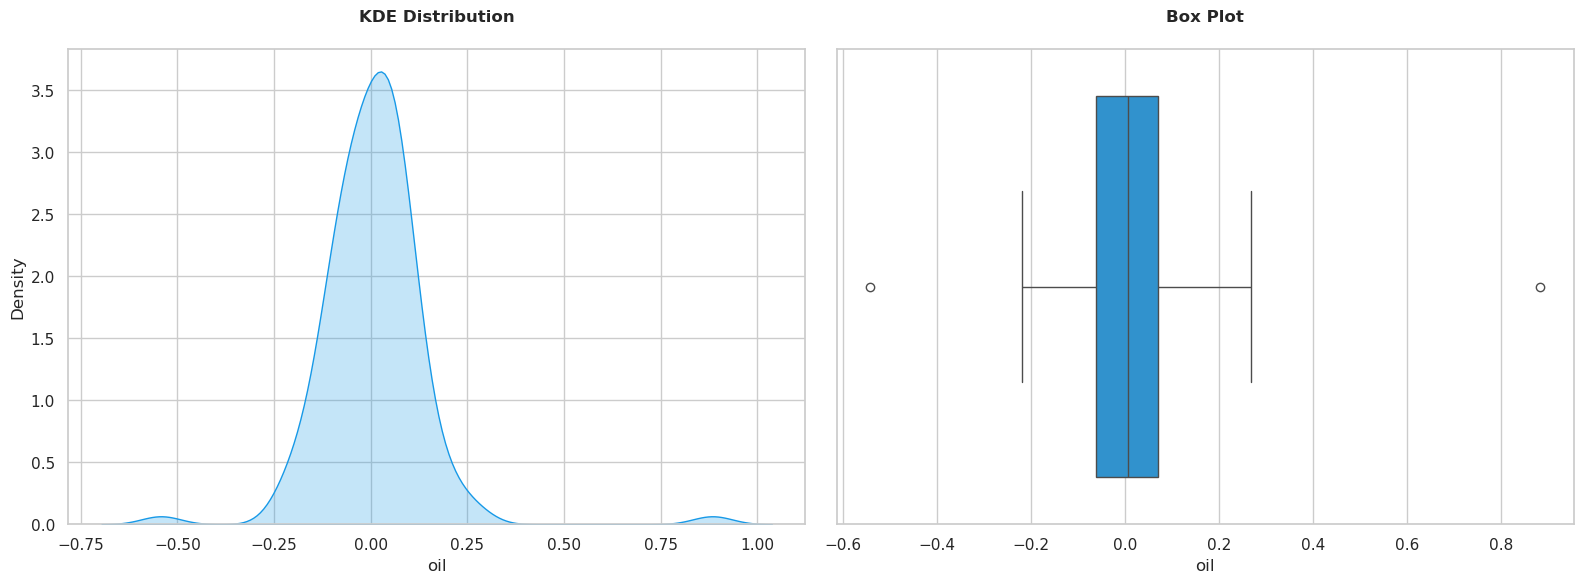

Feature: copper


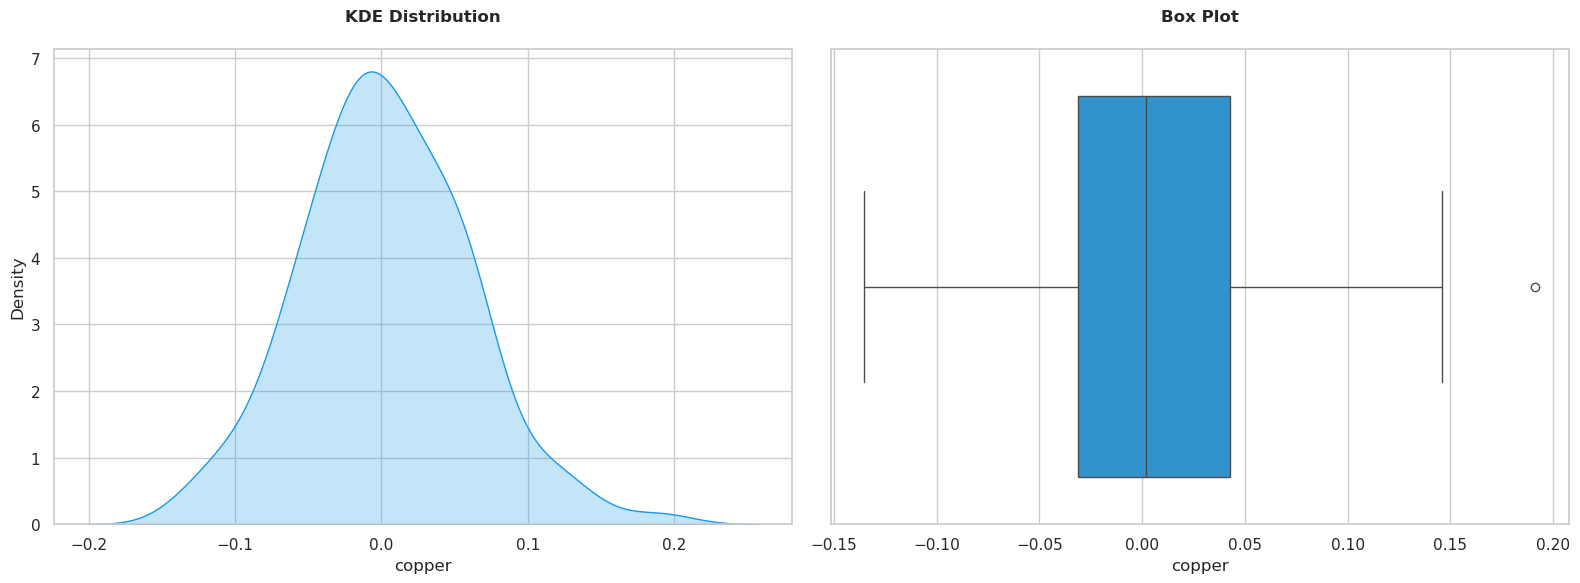

Feature: aluminium


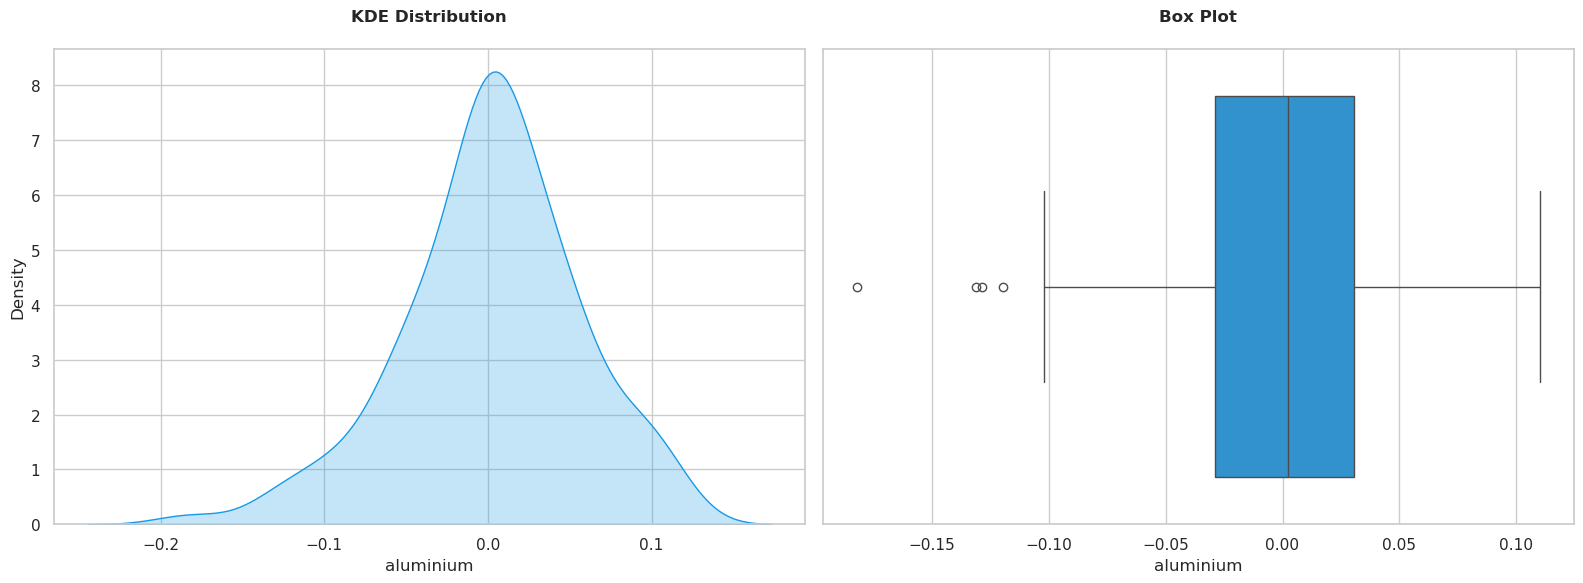

Feature: palladium


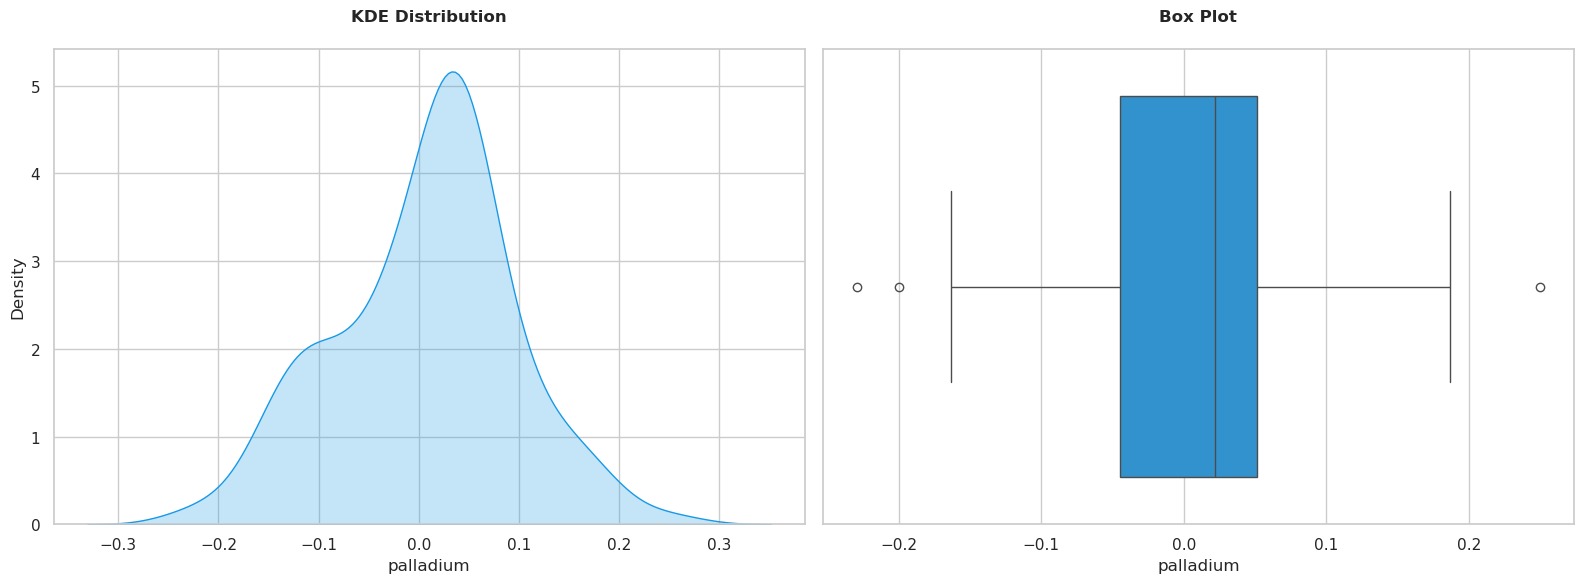

Feature: natural_gas


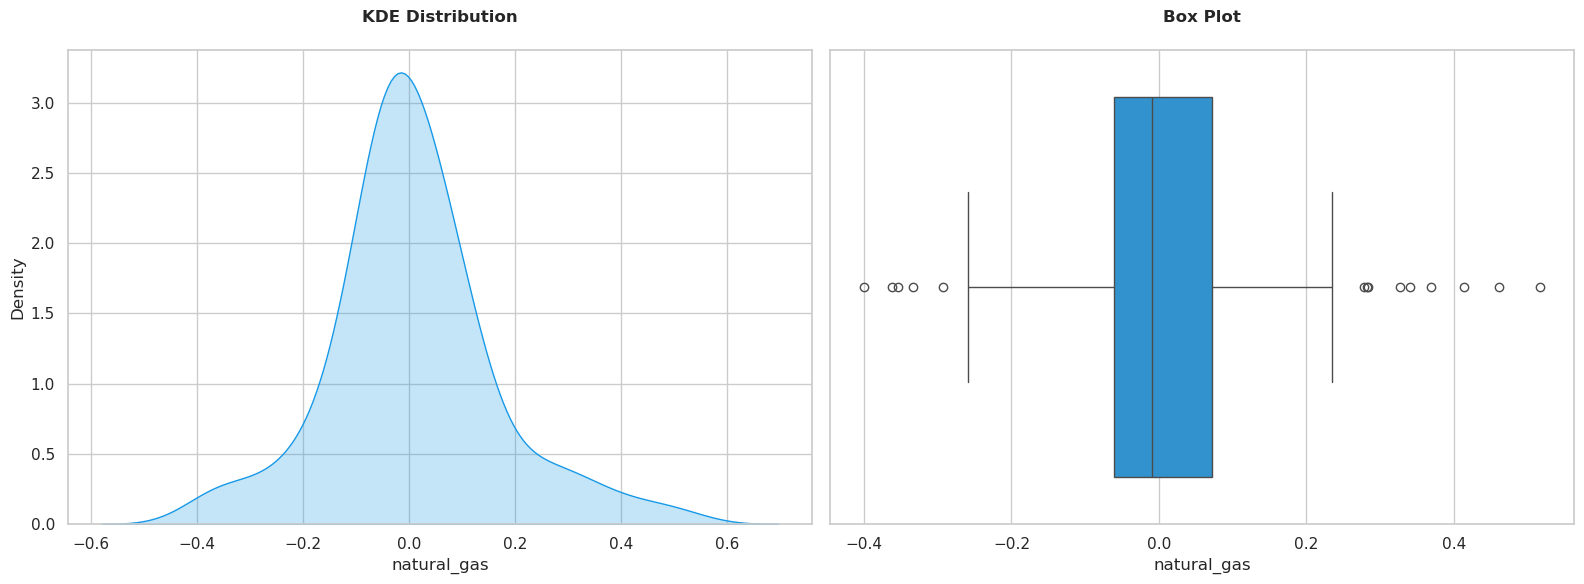

Feature: wheat


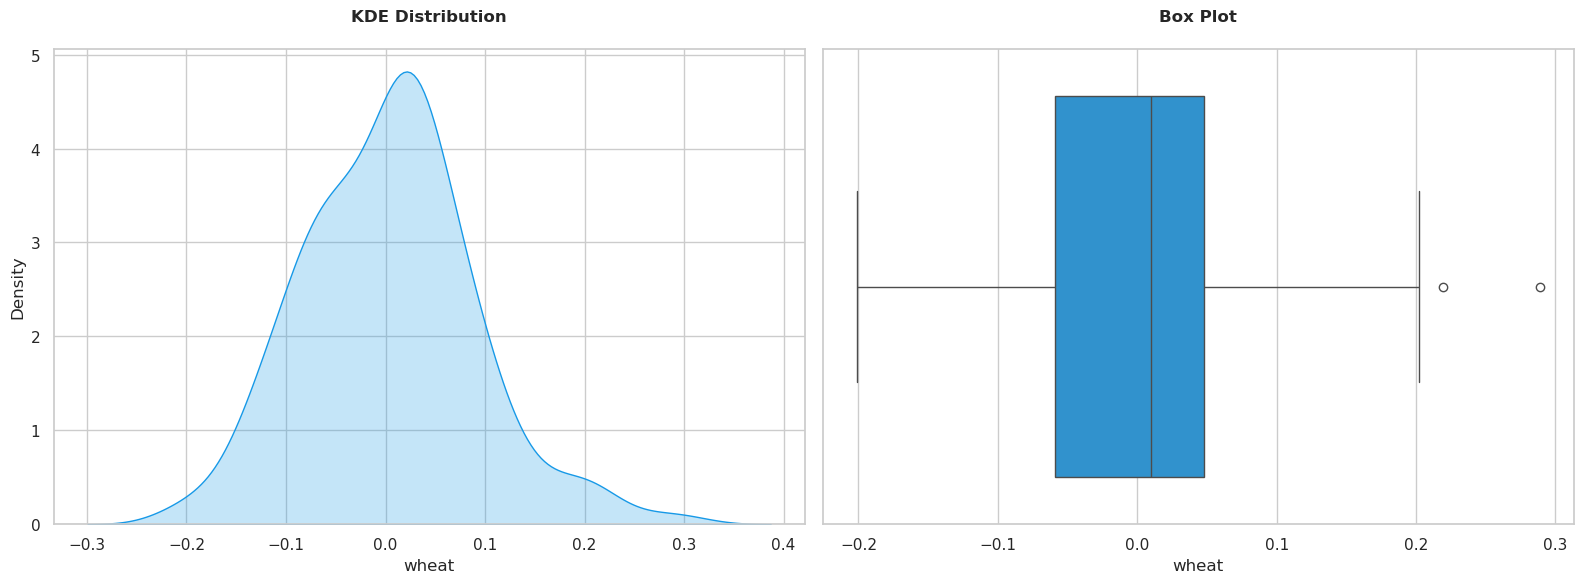

Feature: soybean


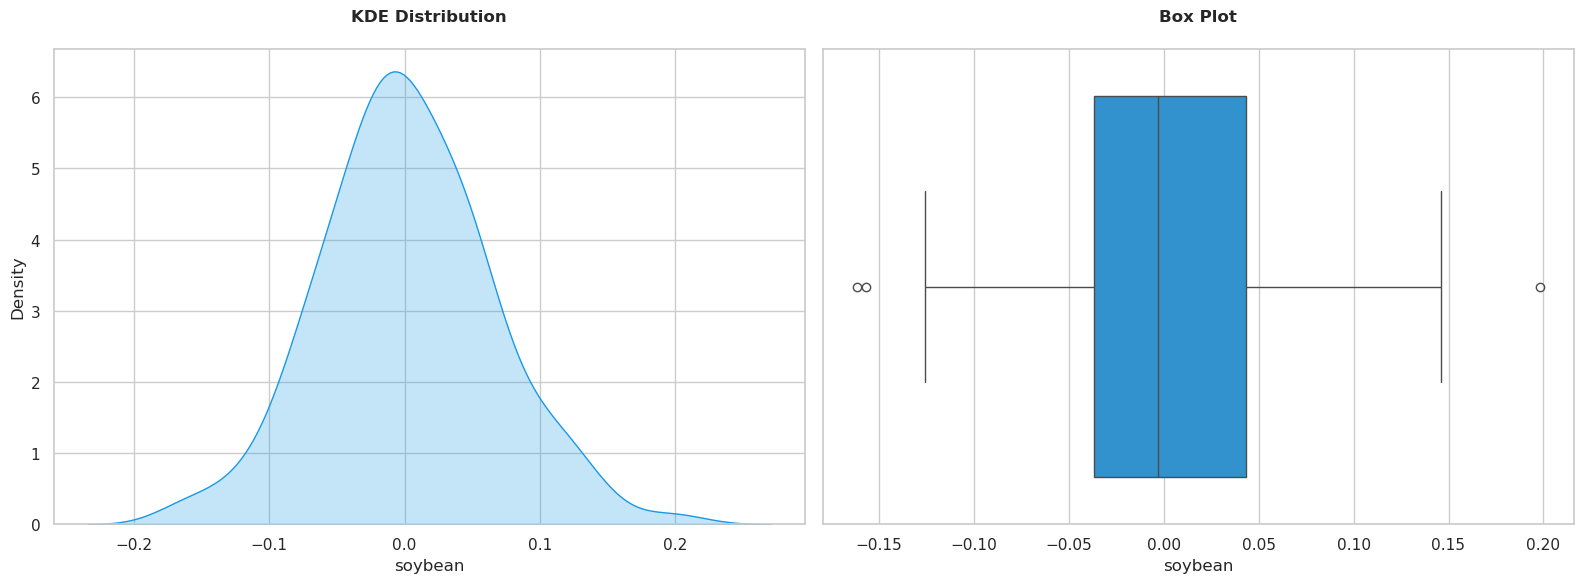

Feature: coffee


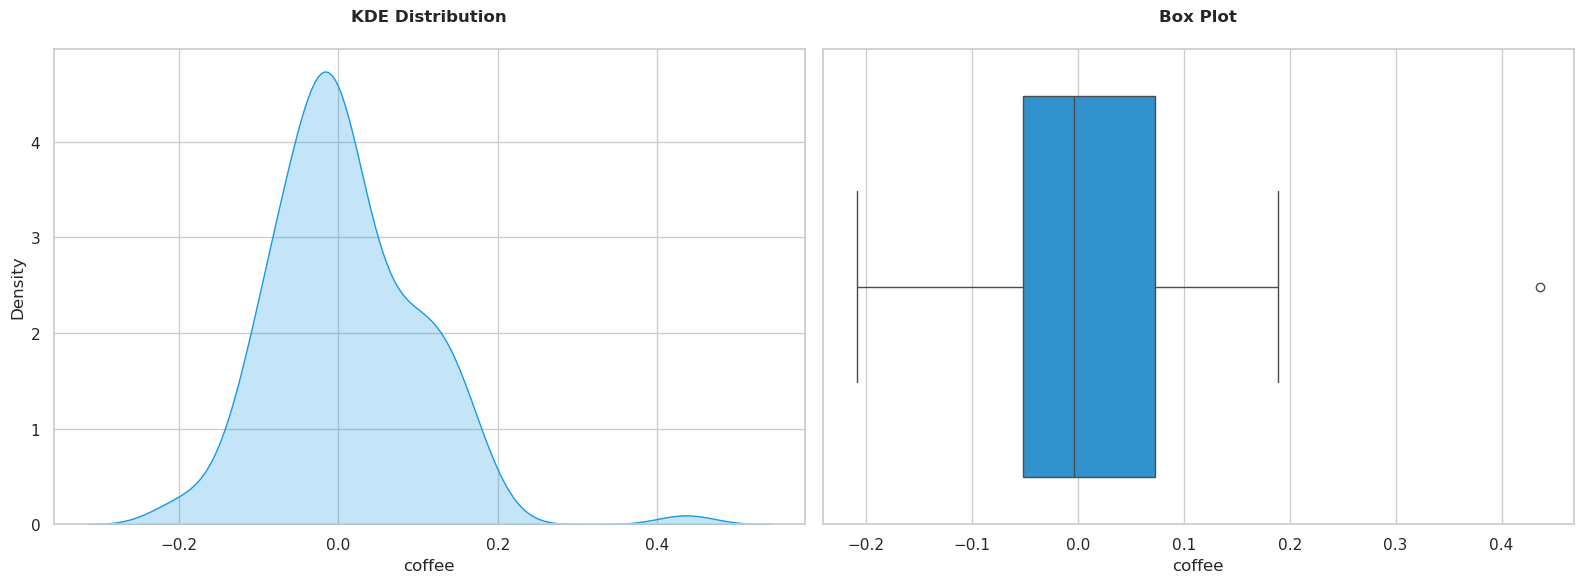

Feature: corn


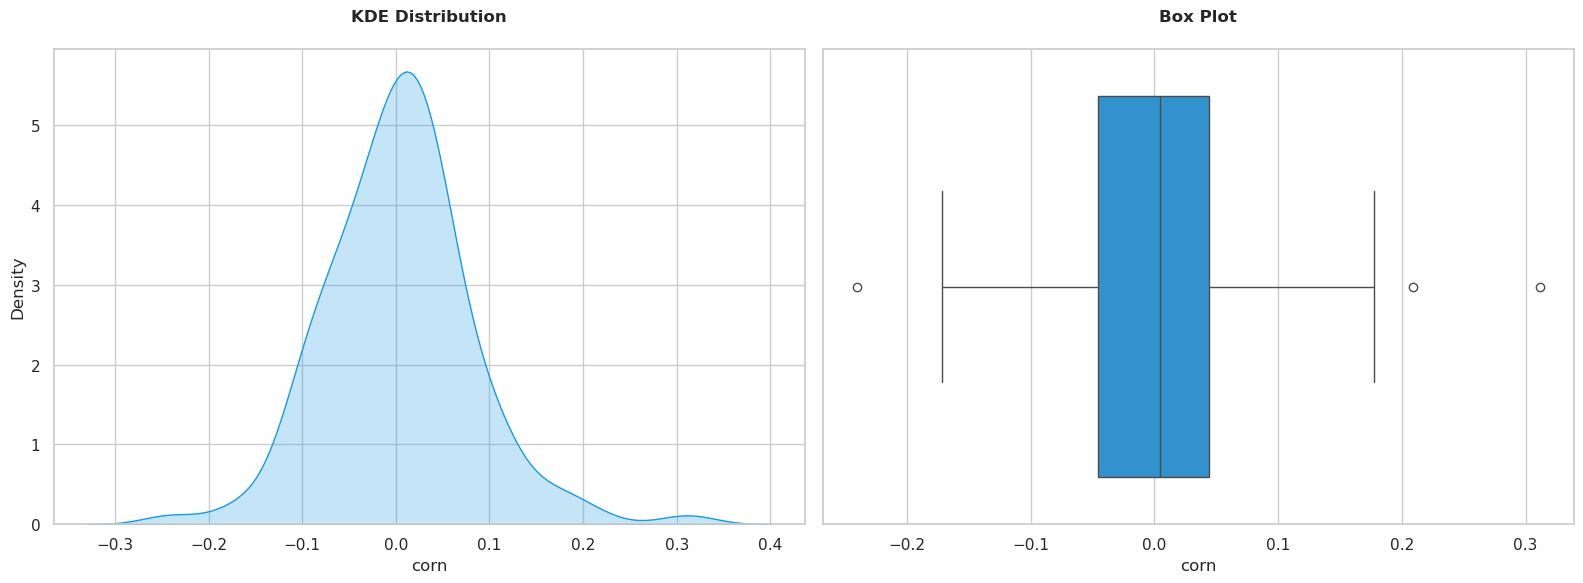

Feature: sugar


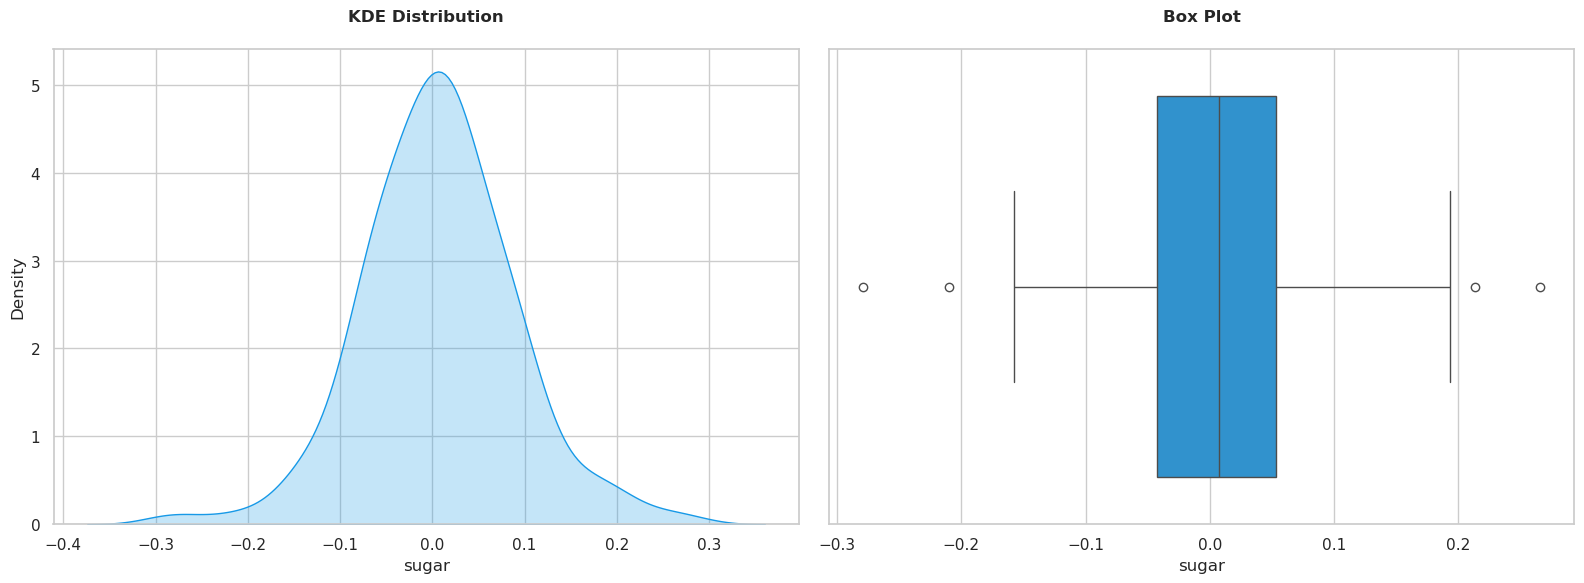

Feature: cotton


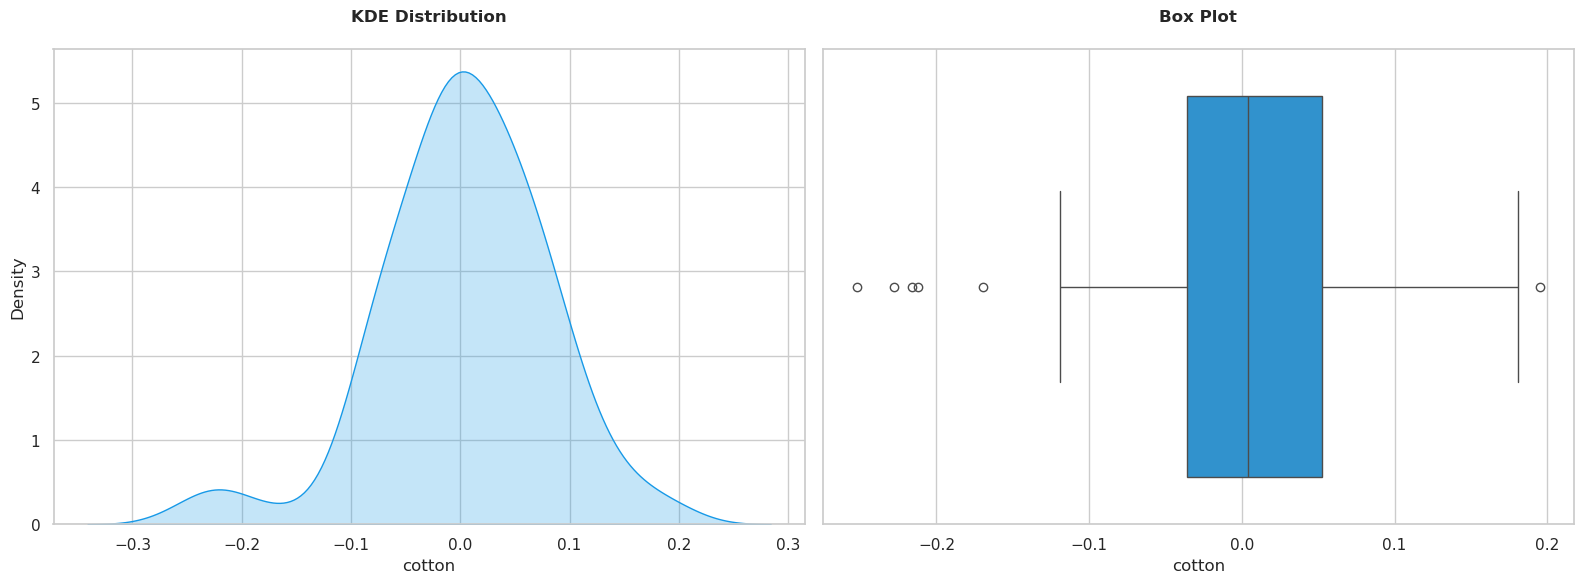

Feature: unemployment


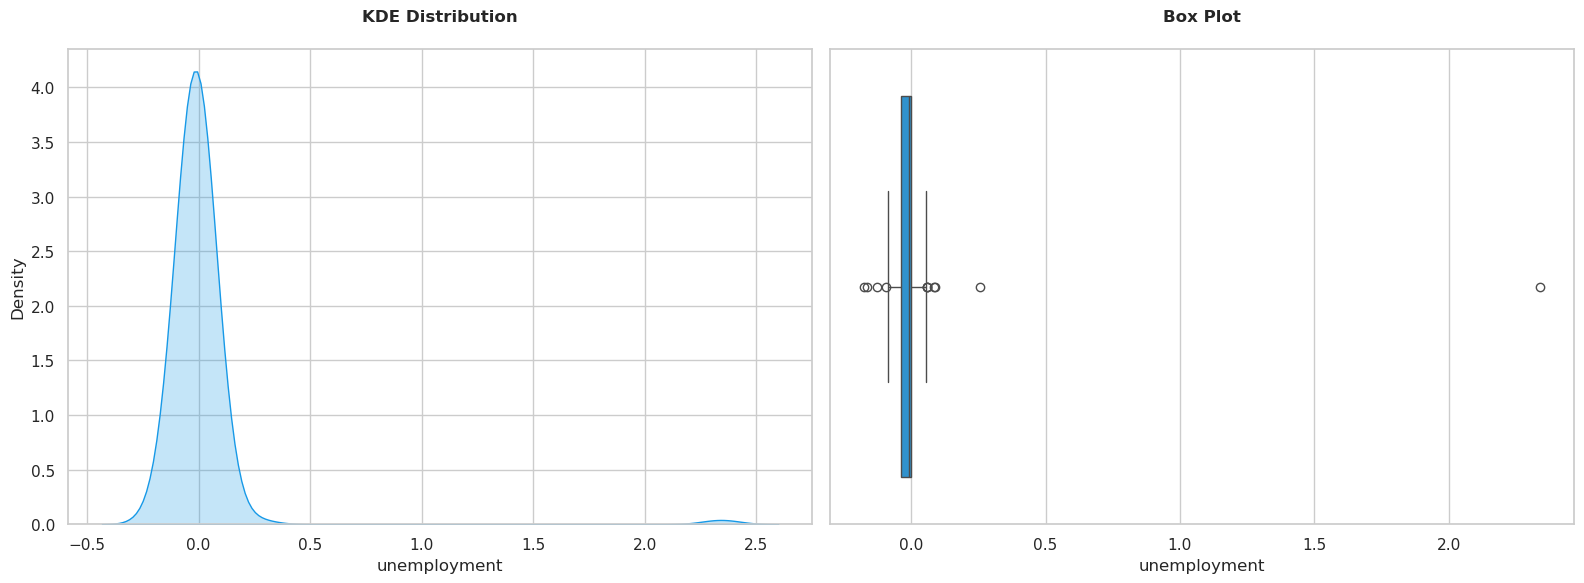

Feature: federal_budget_deficit


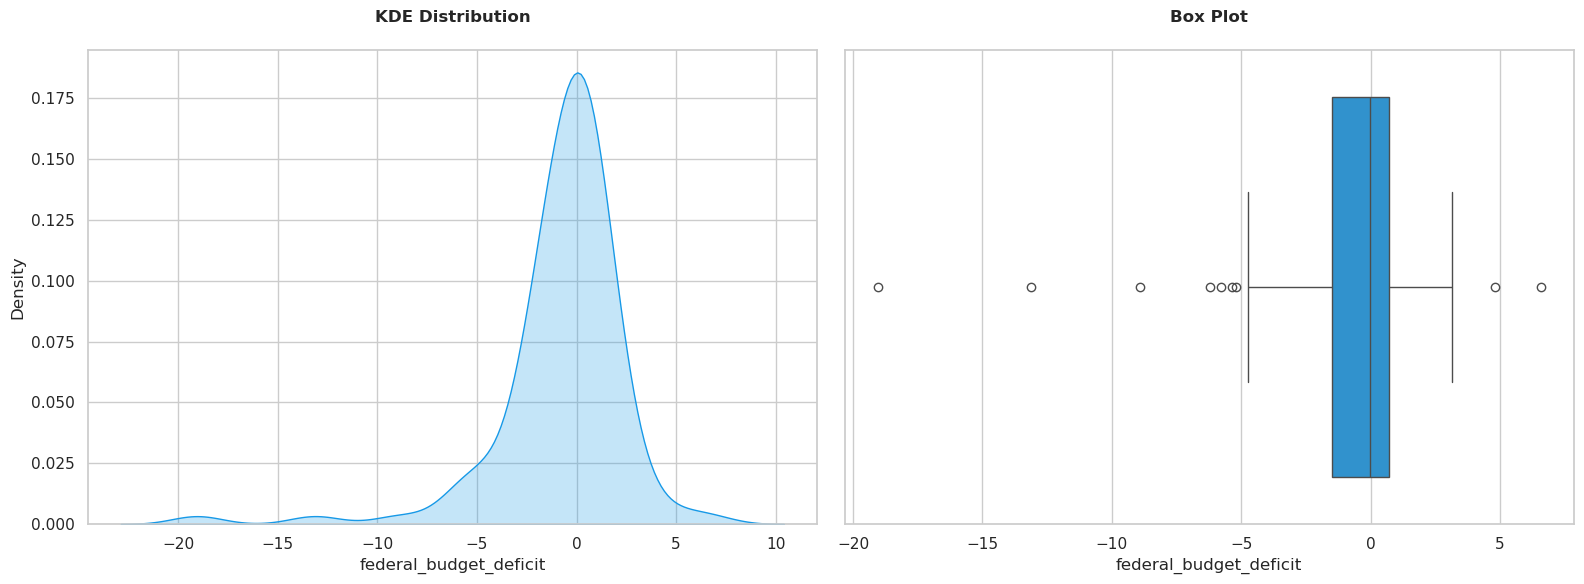

Feature: housing_starts


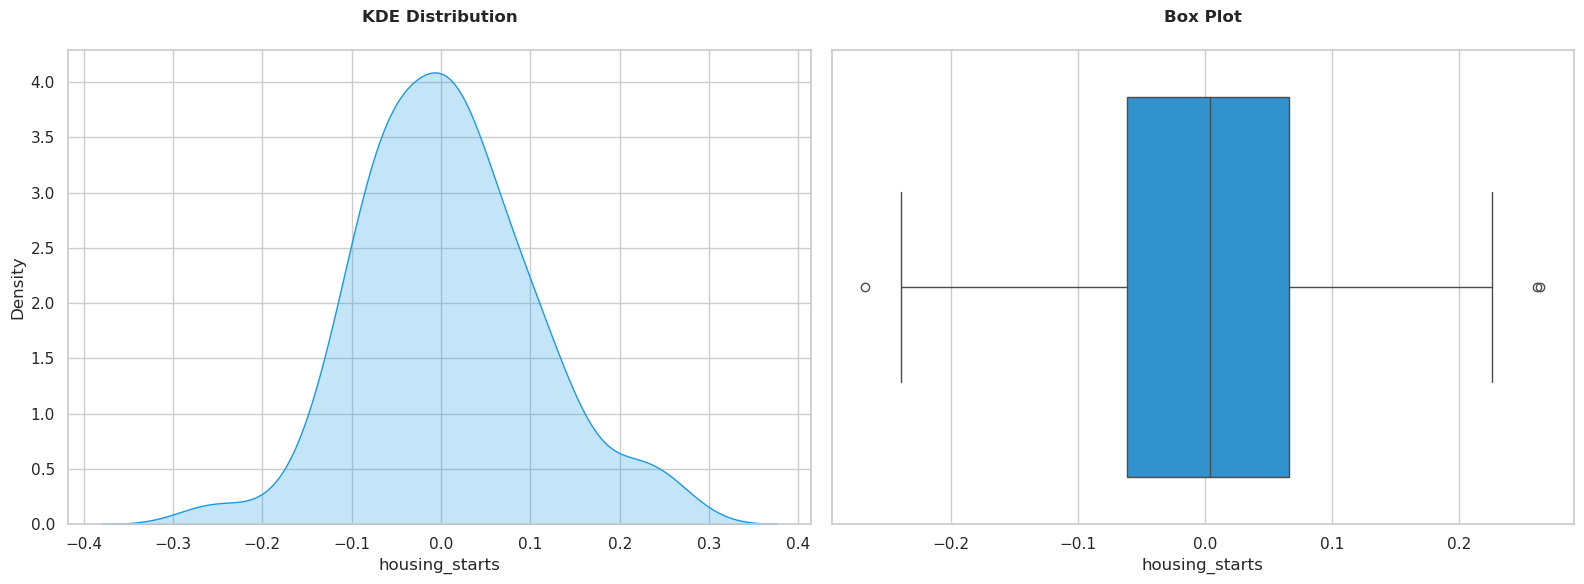

Feature: gdp_real


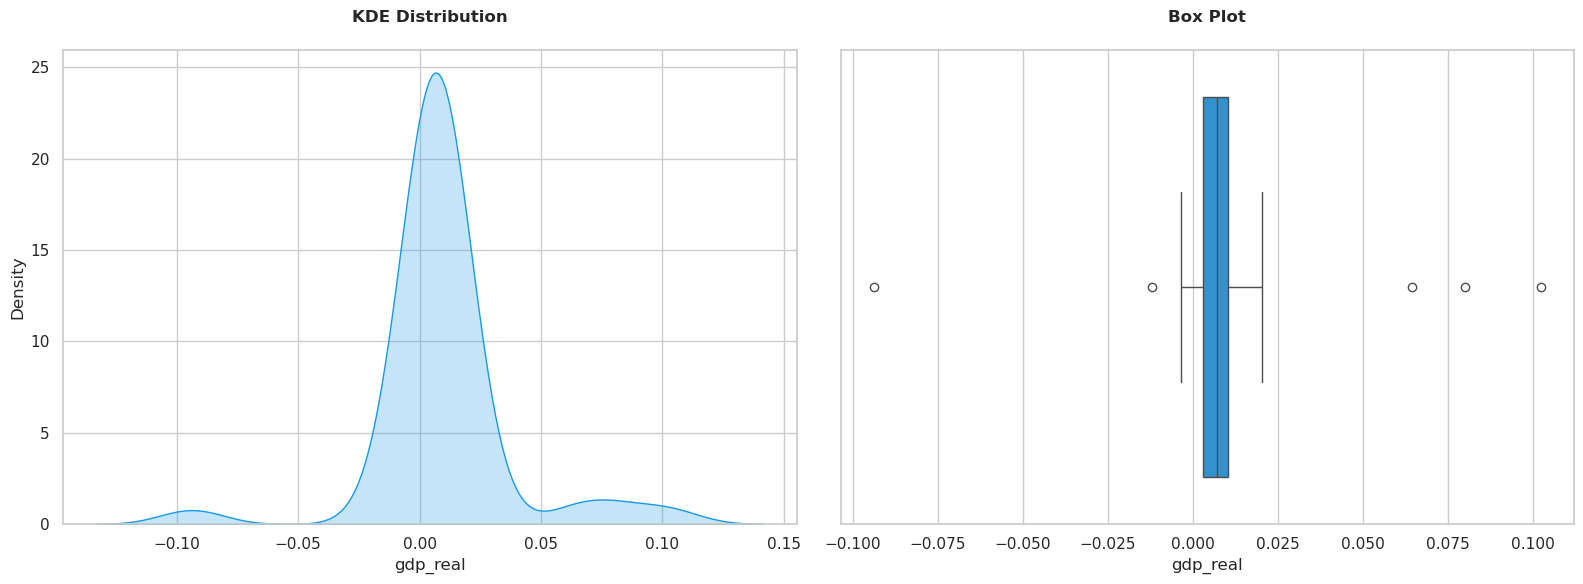

Feature: avg_home_price


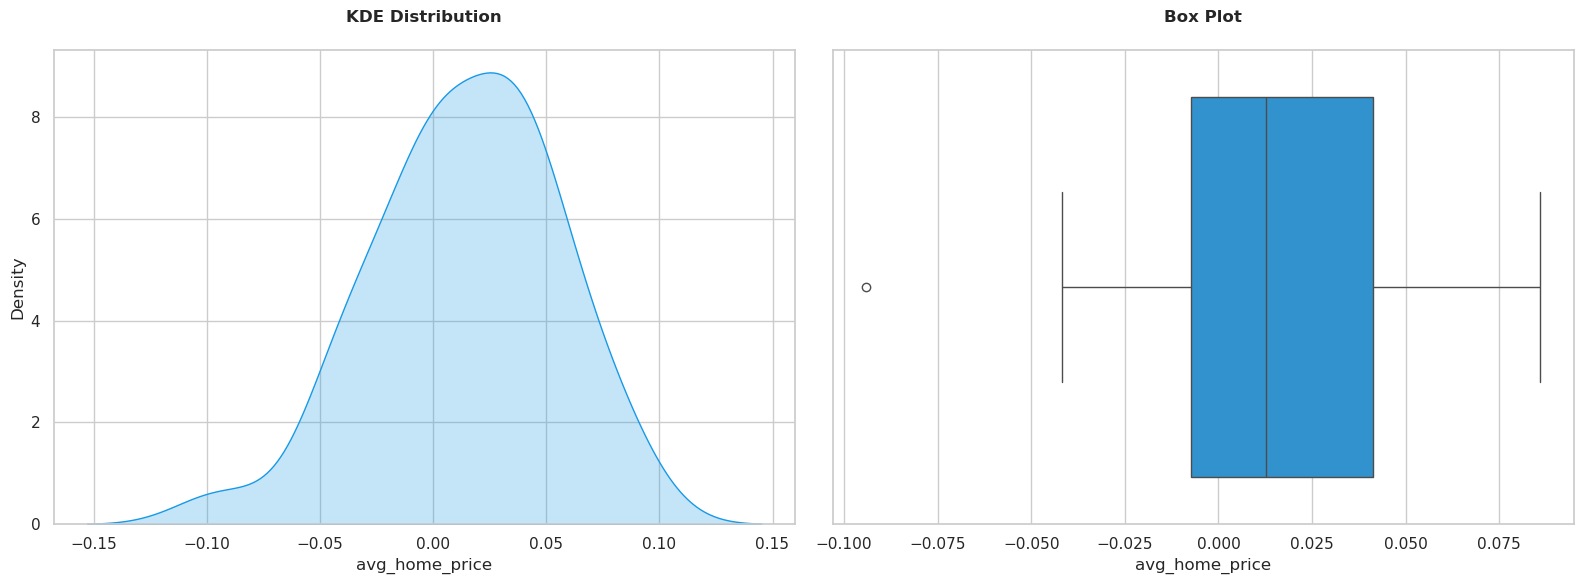

Feature: 30yr-15yr Mortgage Rate Spread


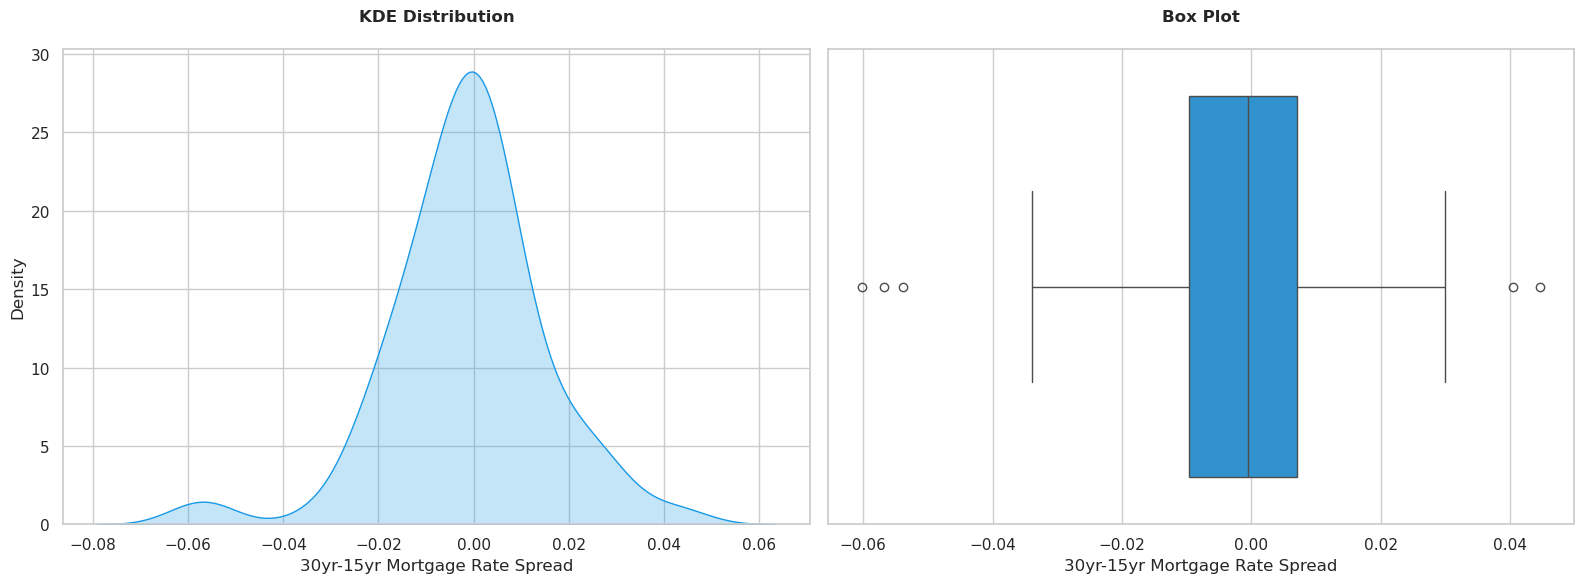

Feature: BAA-AAA Corporate Bond Spread


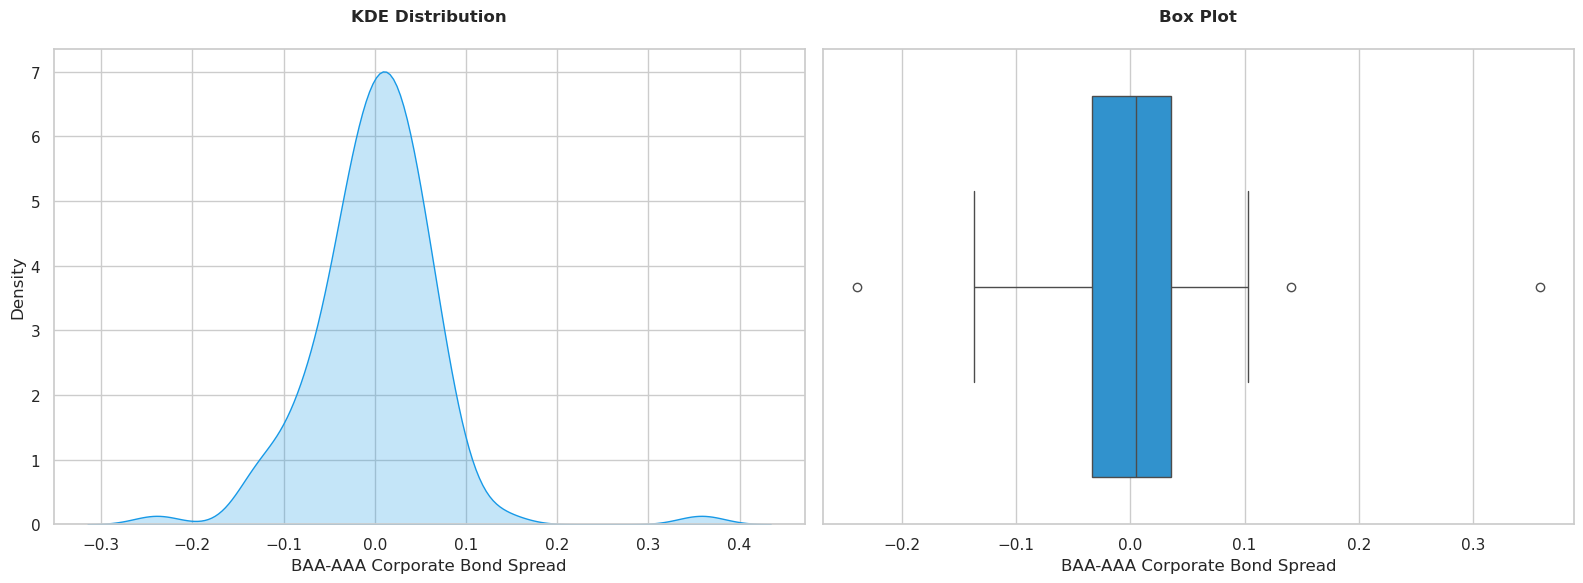

Feature: 10yr-2yr Treasury Spread


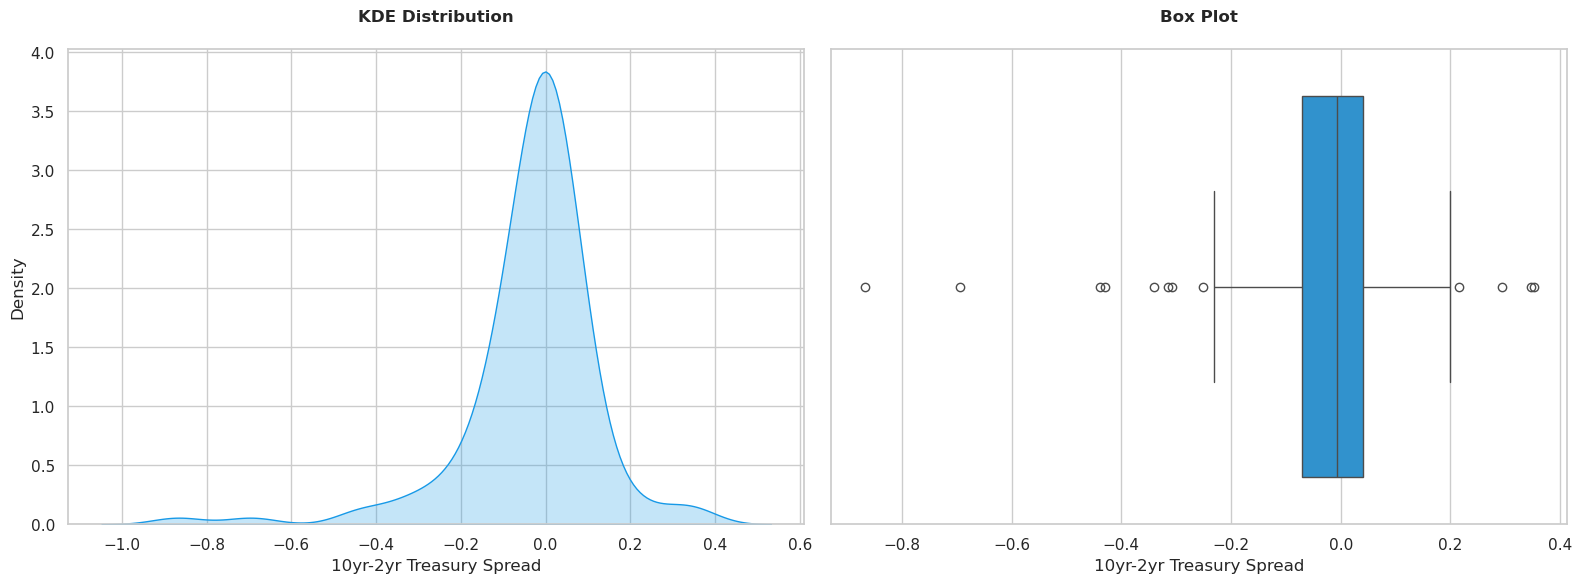

Feature: cpi


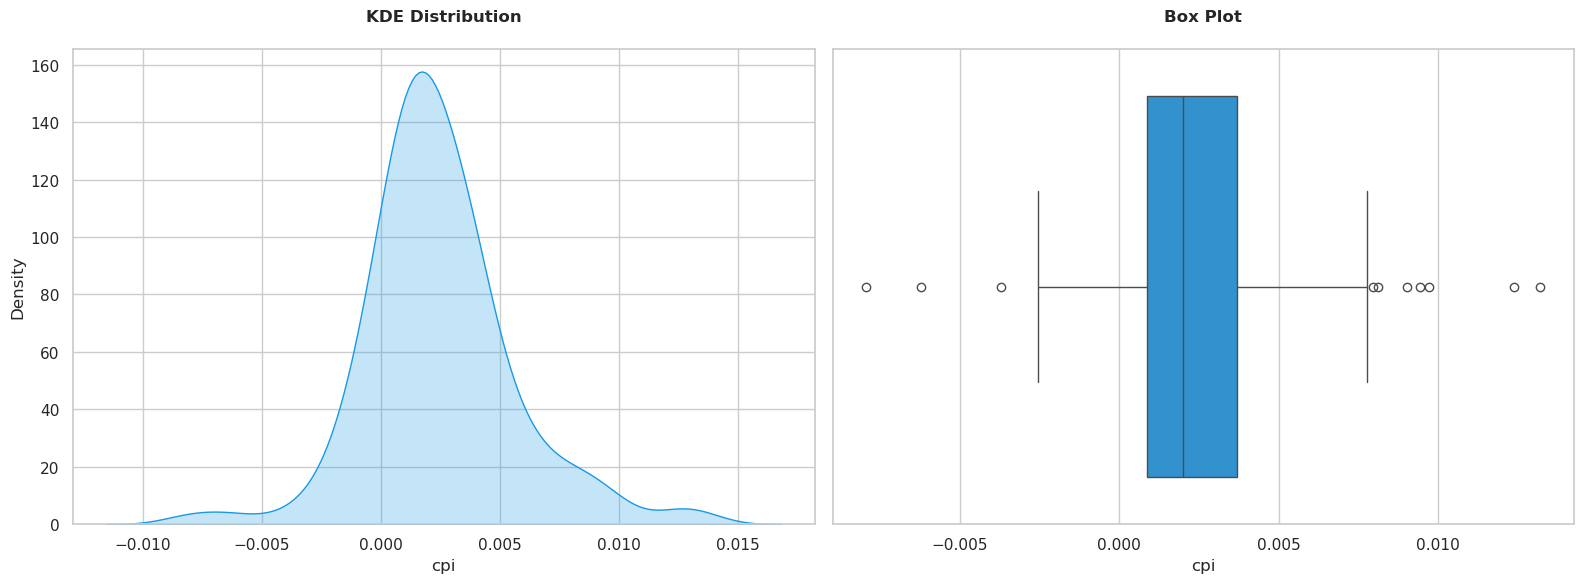

In [17]:
econ_df = df[['date'] + utils.features_econ]
econ_df = econ_df.drop_duplicates('date')

for feat in utils.features_econ:
	print(f'Feature: {feat}')
	utils.plot.dist(econ_df[feat])

The economic indicators generally have an approximate normal distribution with some skews. VIX would likely benifit from a log transformation given it's derived from derivative contracts and thus has a non-linear relationship with the underlying asset. Log is also a common transformation applied to VIX.

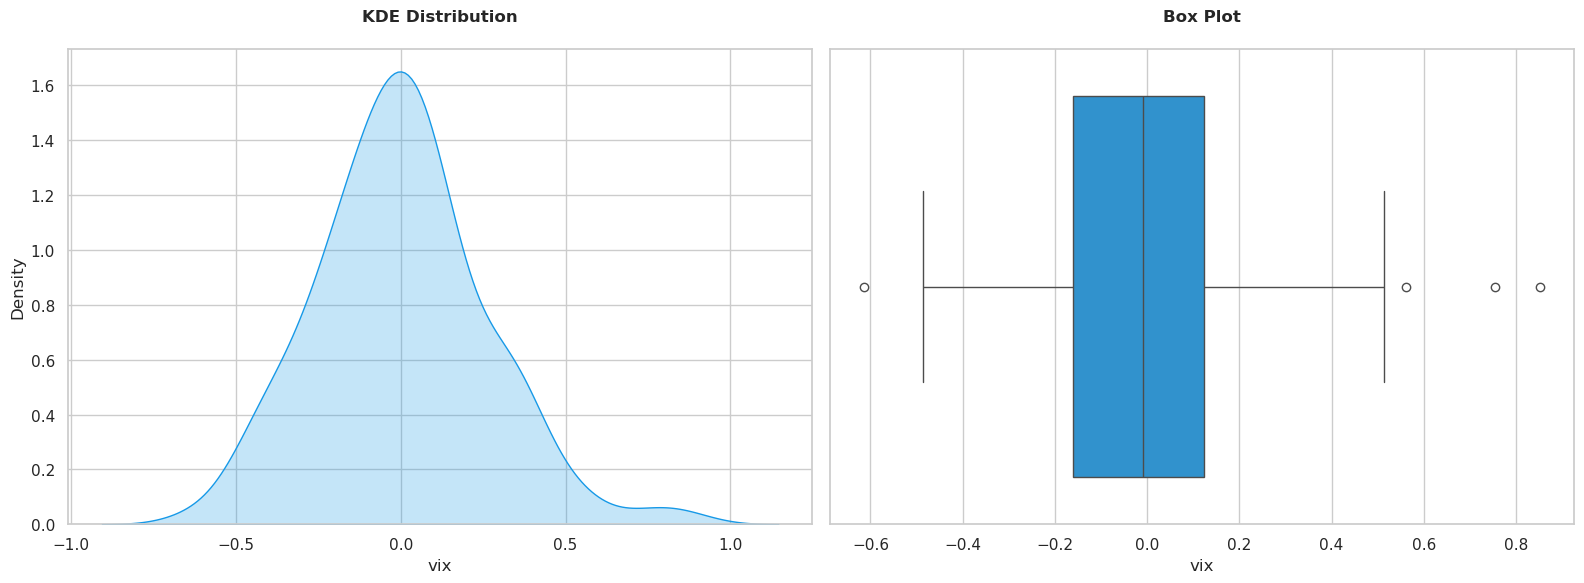

In [18]:
rates = ['vix']
for rate in rates:
	df[rate] = df[rate].apply(np.log1p)
	utils.plot.dist(df.drop_duplicates('date')[rate])

The resulting distribution of VIX is nearly normal after the log transformation, the other economic indicators would likely not benefit from a similar transformation given their relationship to the market is not as directly non-linear. A transformation of other variables may also hamper interpretability.

In [19]:
df.to_csv('data/feature_selection.csv', index=False)